# Predicting UEFA 2024 cup winner

## Objective

Can we build a machine learning model to predict the winner of the UEFA Euro 2024 tournament based on historical team and player data? Or in general build a predictive model for figuring out UEFA Euro cup winners based on historical data?

## The Data

There are many source of data for players and teams data, such:

      - Kaggle: Datasets "European Football Database" https://www.kaggle.com/datasets/piterfm/football-soccer-uefa-euro-1960-2024
      - Kaggle: Dataset related https://www.kaggle.com/datasets/damirdizdarevic/uefa-euro-2024-players
      - Fifa National Team ranking (as at June 10th 2024) https://inside.fifa.com/fifa-world-ranking/men?dateId=id14415

## The techniques and Analysis

This is a classification problem so I expect to:

1. Collect data from above listed data sources

2. Perform Data exploration, data cleaning and aggregation as needed

3. Train KNN, Logistic Regression, Decision Trees and SVM, also train with Neural Networks

4. Once the best model has been found, apply it to the Euro 2024 roster and predict both individual games and final winner.

## Expected Results

The model with the best accuracy and f1-score will be deployed for the Euro 2024 predictions


# Exploratory Data Analysis

In [1]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Importing ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


# Enabling Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Games dataset analysis


In [2]:
# Load Data
# Note_to_self: use OS walk

df = pd.read_csv('./drive/MyDrive/ML-Capstone-Data/friendly_2021-2024.csv', parse_dates=['date'])
df.head()

# Additional Data (Nation Leaguie)
df_nl19 = pd.read_csv('./drive/MyDrive/ML-Capstone-Data/nationLeague2019.csv', parse_dates=['date'])
df_nl21 = pd.read_csv('./drive/MyDrive/ML-Capstone-Data/nationLeague2021.csv', parse_dates=['date'])
df_nl22 = pd.read_csv('./drive/MyDrive/ML-Capstone-Data/nationLeague2023.csv', parse_dates=['date'])

# Aditonal Data (Euro 2000-2020)
df_euro2000 = pd.read_csv('./drive/MyDrive/ML-Capstone-Data/euro2000.csv', parse_dates=['date'])
df_euro2004 = pd.read_csv('./drive/MyDrive/ML-Capstone-Data/euro2004.csv', parse_dates=['date'])
df_euro2008 = pd.read_csv('./drive/MyDrive/ML-Capstone-Data/euro2008.csv', parse_dates=['date'])
df_euro2012 = pd.read_csv('./drive/MyDrive/ML-Capstone-Data/euro2012.csv', parse_dates=['date'])
df_euro2016 = pd.read_csv('./drive/MyDrive/ML-Capstone-Data/euro2016.csv', parse_dates=['date'])
df_euro2020 = pd.read_csv('./drive/MyDrive/ML-Capstone-Data/euro2020.csv', parse_dates=['date'])


In [3]:
# We Need to join all these data in one big dataframe
df = pd.concat([df, df_nl19, df_nl21, df_nl22, df_euro2000,df_euro2004, df_euro2008, df_euro2012,df_euro2016,df_euro2020])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 997 entries, 0 to 50
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id_match               997 non-null    int64         
 1   home_team              997 non-null    object        
 2   away_team              997 non-null    object        
 3   home_team_code         997 non-null    object        
 4   away_team_code         994 non-null    object        
 5   home_score             985 non-null    float64       
 6   away_score             985 non-null    float64       
 7   home_penalty           21 non-null     float64       
 8   away_penalty           21 non-null     float64       
 9   home_score_total       985 non-null    float64       
 10  away_score_total       985 non-null    float64       
 11  winner                 762 non-null    object        
 12  winner_reason          985 non-null    object        
 13  year       

In [4]:
# check columns
df.columns

Index(['id_match', 'home_team', 'away_team', 'home_team_code',
       'away_team_code', 'home_score', 'away_score', 'home_penalty',
       'away_penalty', 'home_score_total', 'away_score_total', 'winner',
       'winner_reason', 'year', 'date', 'date_time', 'utc_offset_hours',
       'group_name', 'matchday_name', 'condition_humidity', 'condition_pitch',
       'condition_temperature', 'condition_weather', 'condition_wind_speed',
       'status', 'type', 'round', 'round_mode', 'round_mode_detail',
       'match_attendance', 'stadium_id', 'stadium_country_code',
       'stadium_capacity', 'stadium_latitude', 'stadium_longitude',
       'stadium_pitch_length', 'stadium_pitch_width', 'goals',
       'penalties_missed', 'penalties', 'red_cards', 'game_referees',
       'stadium_city', 'stadium_name', 'stadium_name_media',
       'stadium_name_official', 'stadium_name_event', 'stadium_name_sponsor',
       'home_lineups', 'away_lineups', 'home_coaches', 'away_coaches',
       'events'],
   

In [5]:
# check for null values
df.isnull().sum()

id_match                   0
home_team                  0
away_team                  0
home_team_code             0
away_team_code             3
home_score                12
away_score                12
home_penalty             976
away_penalty             976
home_score_total          12
away_score_total          12
winner                   235
winner_reason             12
year                       0
date                       0
date_time                  1
utc_offset_hours           1
group_name                76
matchday_name              0
condition_humidity       808
condition_pitch          619
condition_temperature    510
condition_weather        519
condition_wind_speed     510
status                     0
type                       0
round                      0
round_mode                 0
round_mode_detail        226
match_attendance         105
stadium_id                 3
stadium_country_code       3
stadium_capacity           3
stadium_latitude           4
stadium_longit

In [6]:
# Drop columns with too many NA values
df.drop(['home_penalty', 'away_penalty', 'condition_humidity', 'condition_pitch', 'condition_temperature', 'condition_weather', 'condition_wind_speed' ],  inplace=True, axis=1)


In [7]:
# Drop more
df.drop(['match_attendance', 'penalties_missed', 'penalties', 'red_cards', 'home_lineups', 'away_lineups', 'home_coaches', 'away_coaches','events', 'round_mode_detail', 'group_name'],  inplace=True, axis=1)

In [8]:
# check again for null values
df.isnull().sum()

id_match                   0
home_team                  0
away_team                  0
home_team_code             0
away_team_code             3
home_score                12
away_score                12
home_score_total          12
away_score_total          12
winner                   235
winner_reason             12
year                       0
date                       0
date_time                  1
utc_offset_hours           1
matchday_name              0
status                     0
type                       0
round                      0
round_mode                 0
stadium_id                 3
stadium_country_code       3
stadium_capacity           3
stadium_latitude           4
stadium_longitude          4
stadium_pitch_length       4
stadium_pitch_width        4
goals                    102
game_referees              0
stadium_city               3
stadium_name               8
stadium_name_media         3
stadium_name_official      3
stadium_name_event         3
stadium_name_s

In [9]:
# Data Transformation
# winner field is NaN when there is a draw, as well as goals when is 0-0
# Replace 'winner' with 'draw' and 'goals' with 0
df['winner'] = df['winner'].fillna('draw')
df['goals'] = df['goals'].fillna(0)


In [10]:
# check again for null values
df.isnull().sum()

id_match                  0
home_team                 0
away_team                 0
home_team_code            0
away_team_code            3
home_score               12
away_score               12
home_score_total         12
away_score_total         12
winner                    0
winner_reason            12
year                      0
date                      0
date_time                 1
utc_offset_hours          1
matchday_name             0
status                    0
type                      0
round                     0
round_mode                0
stadium_id                3
stadium_country_code      3
stadium_capacity          3
stadium_latitude          4
stadium_longitude         4
stadium_pitch_length      4
stadium_pitch_width       4
goals                     0
game_referees             0
stadium_city              3
stadium_name              8
stadium_name_media        3
stadium_name_official     3
stadium_name_event        3
stadium_name_sponsor     11
dtype: int64

In [11]:
# Drop NaN
df.dropna(inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 975 entries, 0 to 50
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id_match               975 non-null    int64         
 1   home_team              975 non-null    object        
 2   away_team              975 non-null    object        
 3   home_team_code         975 non-null    object        
 4   away_team_code         975 non-null    object        
 5   home_score             975 non-null    float64       
 6   away_score             975 non-null    float64       
 7   home_score_total       975 non-null    float64       
 8   away_score_total       975 non-null    float64       
 9   winner                 975 non-null    object        
 10  winner_reason          975 non-null    object        
 11  year                   975 non-null    int64         
 12  date                   975 non-null    datetime64[ns]
 13  date_time  

In [13]:
# Let's get the FIFA ranking for the european nations from https://inside.fifa.com/fifa-world-ranking/men?dateId=id14415
fifa_euro_ranking = pd.DataFrame({'Rank': [2,3,5,6,7,8,9,10,16,19,21,24,25,26,27,32,34,39,42,45,47,57,66,74], 'Team': ['France', 'Belgium', 'England','Portugal', 'Netherlands', 'Spain', 'Croatia', 'Italy', 'Germany', 'Switzerland', 'Denmark', 'Ukraine', 'Austria','Poland','Hungary', 'Serbia','Czechia','Scotland','Türkiye','Slovakia', 'Romania', 'Slovenia', 'Albania', 'Georgia' ]})
fifa_euro_ranking

,Rank,Team
0,2,France
1,3,Belgium
2,5,England
3,6,Portugal
4,7,Netherlands
5,8,Spain
6,9,Croatia
7,10,Italy
8,16,Germany
9,19,Switzerland


In [14]:
#Let's get the list of Euro 24 group stage finalist
list_2024_teams = ['Albania', 'Austria', 'Belgium', 'Croatia', 'Czechia', 'Denmark', 'England', 'France', 'Georgia', 'Germany', 'Hungary', 'Italy', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Scotland', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'Türkiye', 'Ukraine']

In [15]:
# Filter out from the results dataframe games without any of the Euro 2024 finalists
final_df = df[(df["home_team"].apply(lambda x: x in list_2024_teams)) | (df["away_team"].apply(lambda x: x in list_2024_teams))]
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 648 entries, 0 to 50
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id_match               648 non-null    int64         
 1   home_team              648 non-null    object        
 2   away_team              648 non-null    object        
 3   home_team_code         648 non-null    object        
 4   away_team_code         648 non-null    object        
 5   home_score             648 non-null    float64       
 6   away_score             648 non-null    float64       
 7   home_score_total       648 non-null    float64       
 8   away_score_total       648 non-null    float64       
 9   winner                 648 non-null    object        
 10  winner_reason          648 non-null    object        
 11  year                   648 non-null    int64         
 12  date                   648 non-null    datetime64[ns]
 13  date_time  

# FEATURE ENGINEERING

Let's build some important features for our final dataset, from the historical matches dataset:

- Percentage wins
- Average goal scored
- Averange goal taken


In [16]:
# % average goal scored

team_name = []
team_goals = []

for team in list_2024_teams:
    total_away = (final_df['away_team'] == team).sum()
    score_away = final_df[final_df['away_team'] == team]['away_score_total'].sum()
    total_home = (final_df['home_team'] == team).sum()
    score_home = final_df[final_df['home_team'] == team]['home_score_total'].sum()
    average_goals = ((score_away+score_home)/(total_away+total_home))
    #print(f'Average goal scored for {team} is {average_goals} per partita')
    team_name.append(team)
    team_goals.append(round(average_goals,4))

avg_goal_scored = pd.DataFrame({'Team': team_name, 'Goal Scored': team_goals})

pd.DataFrame({'Team': team_name, 'Goal Scored': team_goals}).sort_values(by='Goal Scored', ascending=False)

,Team,Goal Scored
8,Georgia,2.0769
12,Netherlands,2.0000
20,Spain,1.9818
2,Belgium,1.9000
17,Serbia,1.8966
14,Portugal,1.7895
7,France,1.6296
4,Czechia,1.6000
3,Croatia,1.4762
9,Germany,1.4262


In [17]:
# Percentage win

team_name = []
avg_win = []

for team in list_2024_teams:
    win = (final_df['winner'] == team).sum()
    total_away = (final_df['away_team'] == team).sum()
    total_home = (final_df['home_team'] == team).sum()
    average_win = (win/(total_away+total_home))*100
    #print(f'Percentage win for {team} is {average_win}')
    team_name.append(team)
    avg_win.append(round(average_win,4))

percentage_wins = pd.DataFrame({'Team': team_name, 'Percentage wins': avg_win})

pd.DataFrame({'Team': team_name, 'Percentage wins': avg_win}).sort_values(by='Percentage wins', ascending=False)

,Team,Percentage wins
20,Spain,63.6364
8,Georgia,61.5385
14,Portugal,61.4035
2,Belgium,60.0000
11,Italy,58.6207
12,Netherlands,57.4468
17,Serbia,55.1724
7,France,53.7037
4,Czechia,48.0000
5,Denmark,47.3684


In [18]:
# Goal conceded

team_name = []
team_goals = []

for team in list_2024_teams:
    total_away = (final_df['away_team'] == team).sum()
    score_away = final_df[final_df['away_team'] == team]['home_score_total'].sum()
    total_home = (final_df['home_team'] == team).sum()
    score_home = final_df[final_df['home_team'] == team]['away_score_total'].sum()
    average_goals = ((score_away+score_home)/(total_away+total_home))
    print(f'Goal Conceded for {team} is {average_goals} per partita')
    team_name.append(team)
    team_goals.append(round(average_goals,4))

average_goal_conceded = pd.DataFrame({'Team': team_name, 'Goal Conceded': team_goals})

pd.DataFrame({'Team': team_name, 'Goal Conceded': team_goals}).sort_values(by='Goal Conceded', ascending=False)

Goal Conceded for Albania is 1.1379310344827587 per partita
Goal Conceded for Austria is 1.0285714285714285 per partita
Goal Conceded for Belgium is 1.15 per partita
Goal Conceded for Croatia is 1.4761904761904763 per partita
Goal Conceded for Czechia is 1.22 per partita
Goal Conceded for Denmark is 1.1578947368421053 per partita
Goal Conceded for England is 1.0208333333333333 per partita
Goal Conceded for France is 1.1296296296296295 per partita
Goal Conceded for Georgia is 0.7692307692307693 per partita
Goal Conceded for Germany is 1.3934426229508197 per partita
Goal Conceded for Hungary is 1.0285714285714285 per partita
Goal Conceded for Italy is 0.8103448275862069 per partita
Goal Conceded for Netherlands is 1.0638297872340425 per partita
Goal Conceded for Poland is 1.1666666666666667 per partita
Goal Conceded for Portugal is 0.9122807017543859 per partita
Goal Conceded for Romania is 1.1666666666666667 per partita
Goal Conceded for Scotland is 1.3214285714285714 per partita
Goal C

,Team,Goal Conceded
22,Türkiye,1.8750
23,Ukraine,1.4848
3,Croatia,1.4762
9,Germany,1.3934
18,Slovakia,1.3226
16,Scotland,1.3214
21,Switzerland,1.2683
4,Czechia,1.2200
13,Poland,1.1667
15,Romania,1.1667


In [19]:
# Merge all the previous calculated featuree
final = pd.merge(percentage_wins, avg_goal_scored, on='Team')
final_2 = pd.merge(final, average_goal_conceded, on='Team')
final_3 = pd.merge(final_2, fifa_euro_ranking, on='Team')
final_3



,Team,Percentage wins,Goal Scored,Goal Conceded,Rank
0,Albania,31.0345,0.9310,1.1379,66
1,Austria,42.8571,1.2571,1.0286,25
2,Belgium,60.0000,1.9000,1.1500,3
3,Croatia,42.8571,1.4762,1.4762,9
4,Czechia,48.0000,1.6000,1.2200,34
5,Denmark,47.3684,1.3947,1.1579,21
6,England,45.8333,1.3958,1.0208,5
7,France,53.7037,1.6296,1.1296,2
8,Georgia,61.5385,2.0769,0.7692,74
9,Germany,39.3443,1.4262,1.3934,16


In [20]:
# Generate a dataset with Euro 24 finalists playing against each other in the last 3 years
final_Euro24_teams_df = df[(df["home_team"].apply(lambda x: x in list_2024_teams)) & (df["away_team"].apply(lambda x: x in list_2024_teams))]
final_Euro24_teams_df.head()

,id_match,home_team,away_team,home_team_code,away_team_code,home_score,away_score,home_score_total,away_score_total,winner,...,stadium_pitch_length,stadium_pitch_width,goals,game_referees,stadium_city,stadium_name,stadium_name_media,stadium_name_official,stadium_name_event,stadium_name_sponsor
10,2040596,Poland,Türkiye,POL,TUR,2.0,1.0,2.0,1.0,Poland,...,105.0,68.0,"[{'phase': 'FIRST_HALF', 'time': {'minute': 12...","[{'name': 'Mihály Káprály', 'role': 'FOURTH_OF...",Warsaw,PGE Narodowy,PGE Narodowy,Stadion Narodowy,Stadion Narodowy,PGE Narodowy
19,2040004,Portugal,Croatia,POR,CRO,1.0,2.0,1.0,2.0,Croatia,...,105.0,68.0,"[{'phase': 'FIRST_HALF', 'time': {'minute': 8,...","[{'name': 'Ricardo Baixinho', 'role': 'FOURTH_...",Oeiras,Nacional Do Jamor,Nacional Do Jamor,Nacional Do Jamor,Nacional Do Jamor,Nacional Do Jamor
22,2040265,Switzerland,Austria,SUI,AUT,1.0,1.0,1.0,1.0,draw,...,105.0,68.0,"[{'phase': 'FIRST_HALF', 'time': {'minute': 5,...","[{'name': 'Marco Serra', 'role': 'ASSISTANT_VI...",St Gallen,Kybunpark,Kybunpark,Arena St. Gallen,Arena St. Gallen,Kybunpark
30,2040589,Poland,Ukraine,POL,UKR,3.0,1.0,3.0,1.0,Poland,...,105.0,68.0,"[{'phase': 'FIRST_HALF', 'time': {'minute': 11...","[{'name': 'Ian Hussin', 'role': 'ASSISTANT_REF...",Warsaw,PGE Narodowy,PGE Narodowy,Stadion Narodowy,Stadion Narodowy,PGE Narodowy
44,2040258,Italy,Türkiye,ITA,TUR,0.0,0.0,0.0,0.0,draw,...,105.0,68.0,0,"[{'name': 'Andreas Heidenreich', 'role': 'ASSI...",Bologna,Stadio Renato Dall'Ara,Renato Dall'Ara,Renato Dall'Ara,Renato Dall'Ara,Stadio Renato Dall'Ara


Please note that the dataset used is related to the last 24 years of friendly games of the Euro 24 teams, which provides a better quality values features we will use for training our models when compared to the last 64 years games (where clearly Spain would not rank 8th but probably in the bottom 50, this covering the reality of a Spanish squad that in the last 25 years has been among the best)

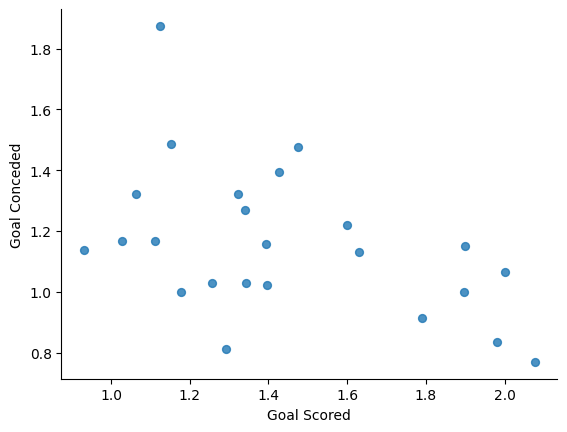

In [21]:
# @title Goal Scored vs Goal Conceded

final_3.plot(kind='scatter', x='Goal Scored', y='Goal Conceded', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

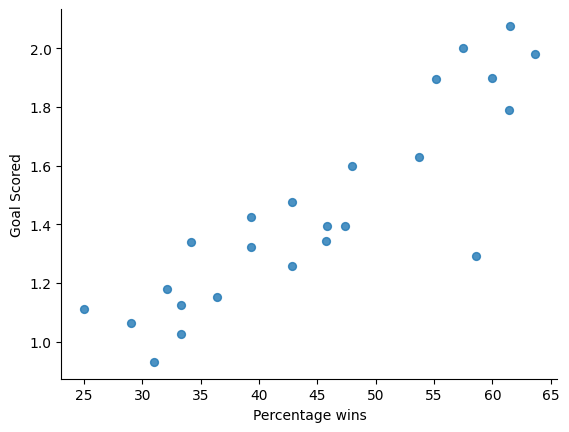

In [22]:
# @title Percentage wins vs Goal Scored

final_3.plot(kind='scatter', x='Percentage wins', y='Goal Scored', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

The above scattered plots seem to state what common sense and domain knowledge suggests, which is that teams with high average goal scored have the highest wins percentage, and that gamers with a team scoring more than two goals typically concede little or nothing and have the highest percentage of wins: in soccer the best defense is to attack!

<Axes: >

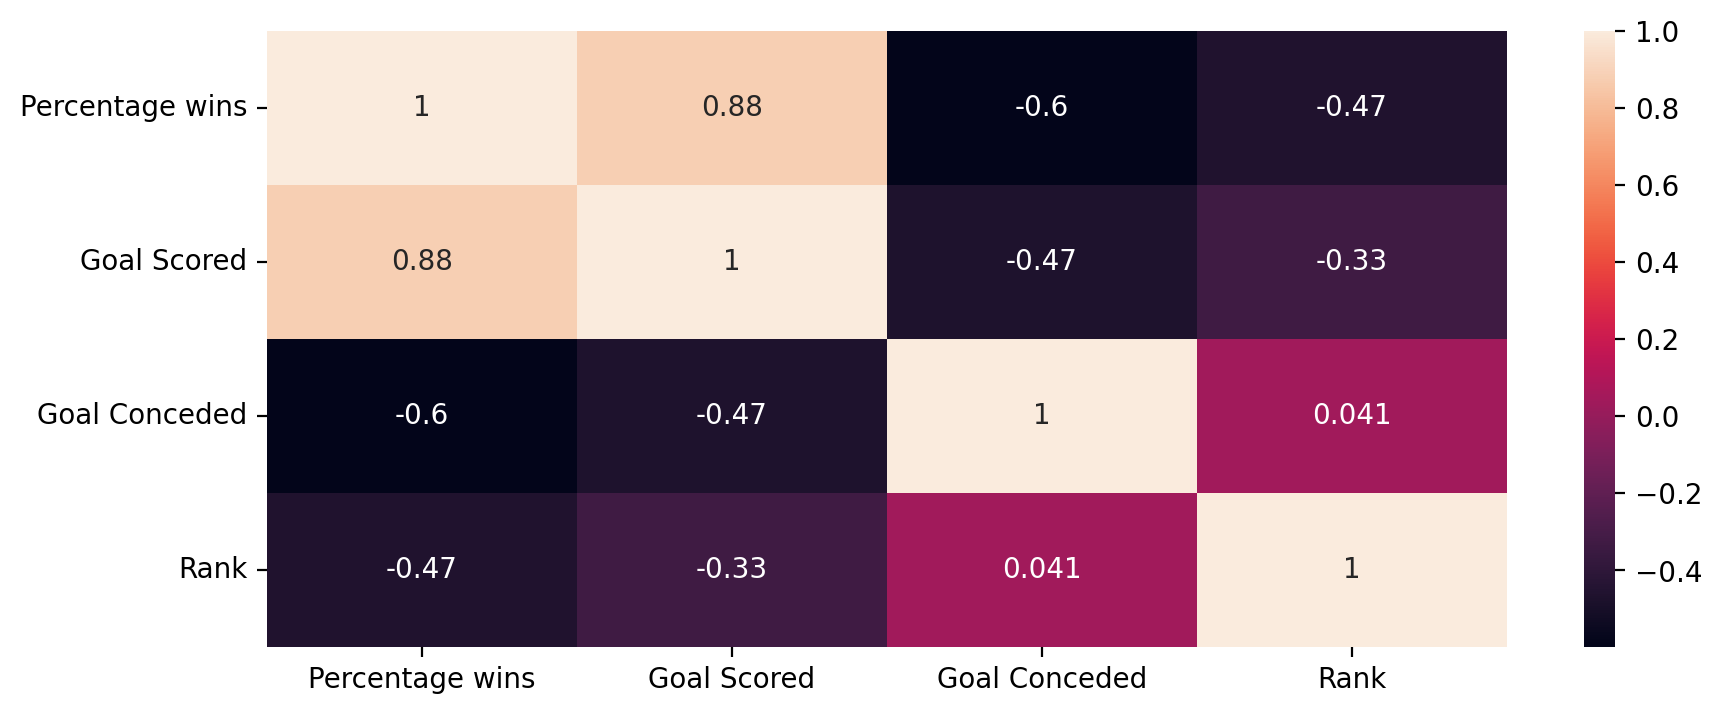

In [23]:
# @title Heatmap
final_4 = final_3.drop(['Team'], axis=1)
plt.figure(figsize=(10, 4), dpi=200)
sns.heatmap(final_4.corr(), annot=True)

In the above heatmap, highest ranking is associated with a lower number, hence the negative correlation between Rank and Percentage wins: it correctly says that the more a team wins, the lower the Rank value will be, which translate in a strong team metrics

## Players data Exploration and feature engineering


In [24]:
# Load friendly games 2021-2024
# df_players = pd.read_csv('./data/euro2024_players.csv')
# From drive:
df_players = pd.read_csv('./drive/MyDrive/euro2024_players.csv')
df_players.tail(10)

,Name,Position,Age,Club,Height,Foot,Caps,Goals,MarketValue,Country
613,Pavel Sulc,Attacking Midfield,23,FC Viktoria Plzen,177,right,1,0,6000000,Czech Republic
614,Antonín Barák,Attacking Midfield,29,ACF Fiorentina,190,left,39,8,4500000,Czech Republic
615,Ondrej Lingr,Attacking Midfield,25,Feyenoord Rotterdam,175,right,13,0,3500000,Czech Republic
616,Matej Jurasek,Right Winger,20,SK Slavia Prague,181,-,1,0,8000000,Czech Republic
617,Vaclav Cerny,Right Winger,26,VfL Wolfsburg,182,left,15,5,7000000,Czech Republic
618,Adam Hlozek,Second Striker,21,Bayer 04 Leverkusen,188,right,31,2,12000000,Czech Republic
619,Patrik Schick,Centre-Forward,28,Bayer 04 Leverkusen,191,left,37,18,22000000,Czech Republic
620,Mojmír Chytil,Centre-Forward,25,SK Slavia Prague,187,-,12,4,6500000,Czech Republic
621,Jan Kuchta,Centre-Forward,27,AC Sparta Prague,185,right,20,3,5000000,Czech Republic
622,Tomas Chory,Centre-Forward,29,FC Viktoria Plzen,199,right,3,2,3200000,Czech Republic


In [25]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         623 non-null    object
 1   Position     623 non-null    object
 2   Age          623 non-null    int64 
 3   Club         623 non-null    object
 4   Height       623 non-null    int64 
 5   Foot         620 non-null    object
 6   Caps         623 non-null    int64 
 7   Goals        623 non-null    int64 
 8   MarketValue  623 non-null    int64 
 9   Country      623 non-null    object
dtypes: int64(5), object(5)
memory usage: 48.8+ KB


Age, Caps, Goals, Position MarketValue and Country seem columns of interests.

* Average player Age by itself when grouped by country is noteworthy feature
* Age & Caps can provide a measure of Experience
* MarketValue can provide a measuure of potential for the Country they belong to

Once we calculate these average for each country, we can add it to the training dataset to have a final picture of the teams going to Euro 2024 based on their performances in the last 3 years and players aggregate data,

In [26]:
# Average age for country
print("Scotland is the oldest team in the Euro 2024 while Czech Republig is the youngest")
print("=======================================")
print(df_players.groupby('Country')['Age'].mean().sort_values(ascending=False).head())
print("=======================================")
print("")
print("Croatia and Portugal are the team with most experienced players in international games Czech Republic is the least")
print("=======================================")
print(df_players.groupby('Country')['Caps'].mean().sort_values(ascending=False).head())
print("=======================================")
print("")
print("England, France and Portugal have the most expensive players in the tournament")
print("=======================================")
print(df_players.groupby('Country')['MarketValue'].mean().sort_values(ascending=False).head())
print("=======================================")
print("")
print("Portugal, France and Belgium have the teams with players at Euro 2024 scoring the most with their national team")
print("=======================================")
print(df_players.groupby('Country')['Goals'].sum().sort_values(ascending=False).head())
print("=======================================")
print("")


Scotland is the oldest team in the Euro 2024 while Czech Republig is the youngest
Country
Scotland       28.230769
Germany        28.115385
Croatia        27.692308
Switzerland    27.692308
Denmark        27.692308
Name: Age, dtype: float64

Croatia and Portugal are the team with most experienced players in international games Czech Republic is the least
Country
Croatia        44.307692
Portugal       42.807692
Switzerland    42.000000
Denmark        41.192308
Belgium        37.960000
Name: Caps, dtype: float64

England, France and Portugal have the most expensive players in the tournament
Country
England     5.826923e+07
France      4.936000e+07
Portugal    4.055769e+07
Spain       3.713462e+07
Germany     3.273077e+07
Name: MarketValue, dtype: float64

Portugal, France and Belgium have the teams with players at Euro 2024 scoring the most with their national team
Country
Portugal    225
France      192
Belgium     177
Poland      154
Croatia     147
Name: Goals, dtype: int64



In [27]:
#create a dataset with the colums the previous cell created

age_mean = df_players.groupby('Country')['Age'].mean().reset_index()
caps_mean = df_players.groupby('Country')['Caps'].mean().reset_index()
market_value_mean = df_players.groupby('Country')['MarketValue'].mean().reset_index()
goals_mean = df_players.groupby('Country')['Goals'].sum().reset_index()

final_players_data = pd.merge(age_mean, caps_mean, on='Country')
final_players_data = pd.merge(final_players_data, market_value_mean, on='Country')
final_players_data = pd.merge(final_players_data, goals_mean, on='Country')

# Rename columns to add the info of how those values are calculated
final_players_data.rename(columns={'Country': 'Team', 'Age': 'Age (mean)', 'Caps': 'Caps (mean)', 'MarketValue': 'MarketValue (mean)', 'Goals': 'Goals (total)'}, inplace=True)

# Align team names across datasets
final_players_data.replace('Turkiye', 'Türkiye', inplace=True)
final_players_data.replace('Czech Republic', 'Czechia', inplace=True)


## Final dataset creation

The final dataset, called training.csv, will be created as reasult of data exploration and feature engineering from the two original datasets loaded.

In [28]:
final_Euro24_teams_df.columns

Index(['id_match', 'home_team', 'away_team', 'home_team_code',
       'away_team_code', 'home_score', 'away_score', 'home_score_total',
       'away_score_total', 'winner', 'winner_reason', 'year', 'date',
       'date_time', 'utc_offset_hours', 'matchday_name', 'status', 'type',
       'round', 'round_mode', 'stadium_id', 'stadium_country_code',
       'stadium_capacity', 'stadium_latitude', 'stadium_longitude',
       'stadium_pitch_length', 'stadium_pitch_width', 'goals', 'game_referees',
       'stadium_city', 'stadium_name', 'stadium_name_media',
       'stadium_name_official', 'stadium_name_event', 'stadium_name_sponsor'],
      dtype='object')

We will need the following features only from the previous dataset:


*   home_team
*   away_team
*   home_score
*   away_score
*   winner


which we will rename into:

*   first_team
*   second_team
*   first_team_score
*   second_team_score
*   final_result








In [29]:
training = final_Euro24_teams_df[['home_team', 'away_team', 'home_score_total', 'away_score_total', 'winner']]
training.rename(columns={'home_team': 'first_team', 'away_team': 'second_team', 'home_score_total': 'first_team_score', 'away_score_total': 'second_team_score', 'winner': 'final_result'}, inplace=True)
training.head()

,first_team,second_team,first_team_score,second_team_score,final_result
10,Poland,Türkiye,2.0,1.0,Poland
19,Portugal,Croatia,1.0,2.0,Croatia
22,Switzerland,Austria,1.0,1.0,draw
30,Poland,Ukraine,3.0,1.0,Poland
44,Italy,Türkiye,0.0,0.0,draw


Next step is to add to the training dataframe the information from the final_4 dataset containing the strenght information about each team

In [31]:
final_4.columns

Index(['Percentage wins', 'Goal Scored', 'Goal Conceded', 'Rank'], dtype='object')

In [32]:
# Generate the final dataset with all teams information (score, result, and team stats)

for col in final_4.columns:
  training[f'first_team_{col}'] = training['first_team'].apply(lambda x: (final_3[final_3['Team'] == x][col]).values[0])
  training[f'second_team_{col}'] = training['second_team'].apply(lambda x: (final_3[final_3['Team'] == x][col]).values[0])

training.head()


,first_team,second_team,first_team_score,second_team_score,final_result,first_team_Percentage wins,second_team_Percentage wins,first_team_Goal Scored,second_team_Goal Scored,first_team_Goal Conceded,second_team_Goal Conceded,first_team_Rank,second_team_Rank
10,Poland,Türkiye,2.0,1.0,Poland,33.3333,33.3333,1.0278,1.1250,1.1667,1.8750,26,42
19,Portugal,Croatia,1.0,2.0,Croatia,61.4035,42.8571,1.7895,1.4762,0.9123,1.4762,6,9
22,Switzerland,Austria,1.0,1.0,draw,34.1463,42.8571,1.3415,1.2571,1.2683,1.0286,19,25
30,Poland,Ukraine,3.0,1.0,Poland,33.3333,36.3636,1.0278,1.1515,1.1667,1.4848,26,24
44,Italy,Türkiye,0.0,0.0,draw,58.6207,33.3333,1.2931,1.1250,0.8103,1.8750,10,42


Lastly, integrate the data gathered from the player's dataset into the training one, so to have one nice polished dataset we can use to train our models

In [33]:
#Generate the final dataset with all teams information from final_players_data dataset (Age (mean),Caps (mean),MarketValue (mean),Goals (total))
for col in final_players_data.columns:
  training[f'first_team_{col}'] = training['first_team'].apply(lambda x: (final_players_data[final_players_data['Team'] == x][col]).values[0])
  training[f'second_team_{col}'] = training['second_team'].apply(lambda x: (final_players_data[final_players_data['Team'] == x][col]).values[0])

# Remove duplicate
training.drop("first_team_Team",inplace=True, axis=1)
training.drop("second_team_Team",inplace=True, axis=1)

# Check result
training.head()



,first_team,second_team,first_team_score,second_team_score,final_result,first_team_Percentage wins,second_team_Percentage wins,first_team_Goal Scored,second_team_Goal Scored,first_team_Goal Conceded,...,first_team_Rank,second_team_Rank,first_team_Age (mean),second_team_Age (mean),first_team_Caps (mean),second_team_Caps (mean),first_team_MarketValue (mean),second_team_MarketValue (mean),first_team_Goals (total),second_team_Goals (total)
10,Poland,Türkiye,2.0,1.0,Poland,33.3333,33.3333,1.0278,1.1250,1.1667,...,26,42,27.555556,25.807692,30.555556,24.307692,7.866667e+06,1.246538e+07,154,71
19,Portugal,Croatia,1.0,2.0,Croatia,61.4035,42.8571,1.7895,1.4762,0.9123,...,6,9,26.961538,27.692308,42.807692,44.307692,4.055769e+07,1.260385e+07,225,147
22,Switzerland,Austria,1.0,1.0,draw,34.1463,42.8571,1.3415,1.2571,1.2683,...,19,25,27.692308,26.807692,42.000000,23.576923,1.084615e+07,9.057692e+06,125,93
30,Poland,Ukraine,3.0,1.0,Poland,33.3333,36.3636,1.0278,1.1515,1.1667,...,26,24,27.555556,26.346154,30.555556,32.653846,7.866667e+06,1.457692e+07,154,114
44,Italy,Türkiye,0.0,0.0,draw,58.6207,33.3333,1.2931,1.1250,0.8103,...,10,42,26.500000,25.807692,20.346154,24.307692,2.713462e+07,1.246538e+07,59,71


In [34]:
# replace values in final_result with 1 if is first_team,  2 if is second_team and 0 if is a draw
training['final_result'] = training.apply(lambda row: 1 if row['final_result'] == row['first_team'] else (2 if row['final_result'] == row['second_team'] else 0), axis=1)
training.head()

,first_team,second_team,first_team_score,second_team_score,final_result,first_team_Percentage wins,second_team_Percentage wins,first_team_Goal Scored,second_team_Goal Scored,first_team_Goal Conceded,...,first_team_Rank,second_team_Rank,first_team_Age (mean),second_team_Age (mean),first_team_Caps (mean),second_team_Caps (mean),first_team_MarketValue (mean),second_team_MarketValue (mean),first_team_Goals (total),second_team_Goals (total)
10,Poland,Türkiye,2.0,1.0,1,33.3333,33.3333,1.0278,1.1250,1.1667,...,26,42,27.555556,25.807692,30.555556,24.307692,7.866667e+06,1.246538e+07,154,71
19,Portugal,Croatia,1.0,2.0,2,61.4035,42.8571,1.7895,1.4762,0.9123,...,6,9,26.961538,27.692308,42.807692,44.307692,4.055769e+07,1.260385e+07,225,147
22,Switzerland,Austria,1.0,1.0,0,34.1463,42.8571,1.3415,1.2571,1.2683,...,19,25,27.692308,26.807692,42.000000,23.576923,1.084615e+07,9.057692e+06,125,93
30,Poland,Ukraine,3.0,1.0,1,33.3333,36.3636,1.0278,1.1515,1.1667,...,26,24,27.555556,26.346154,30.555556,32.653846,7.866667e+06,1.457692e+07,154,114
44,Italy,Türkiye,0.0,0.0,0,58.6207,33.3333,1.2931,1.1250,0.8103,...,10,42,26.500000,25.807692,20.346154,24.307692,2.713462e+07,1.246538e+07,59,71


In [35]:
# Finally, drop 'first_team_score' and 'second_team_score' from the training data
training.drop(['first_team_score', 'second_team_score'],  inplace=True, axis=1)

In [36]:
# Save original datasets to google drive
# df.to_csv('./drive/MyDrive/friendly_2021-2024.csv', index=False)
# df_players.to_csv('./drive/MyDrive/euro2024_players.csv', index=False)
# Save training dataset to google drive
training.to_csv('./drive/MyDrive/training.csv', index=False)

# Train the Model for the Group stage (where draw is possible)

In [37]:
# Make a copy of training
training4model = training.copy()
training4model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313 entries, 10 to 50
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   first_team                      313 non-null    object 
 1   second_team                     313 non-null    object 
 2   final_result                    313 non-null    int64  
 3   first_team_Percentage wins      313 non-null    float64
 4   second_team_Percentage wins     313 non-null    float64
 5   first_team_Goal Scored          313 non-null    float64
 6   second_team_Goal Scored         313 non-null    float64
 7   first_team_Goal Conceded        313 non-null    float64
 8   second_team_Goal Conceded       313 non-null    float64
 9   first_team_Rank                 313 non-null    int64  
 10  second_team_Rank                313 non-null    int64  
 11  first_team_Age (mean)           313 non-null    float64
 12  second_team_Age (mean)          313 non-n

In [38]:
#list if the dataframe is balanced

print(training['final_result'].value_counts()[0])
print(training['final_result'].value_counts()[1])
print(training['final_result'].value_counts()[2])


66
131
116


This means f1-score will be a better measure of accuracy than the accuracy metric

In [39]:
# Separate data and predictions
X = training4model.drop('final_result',axis=1)
y = training4model['final_result']

In [41]:
#remove index from y
y = y.reset_index(drop=True)


In [45]:
# Create split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [46]:
#One Hot Encoder
categories_to_encode = ['first_team', 'second_team']

# Create the encoder
encoder = OneHotEncoder()

# Fit only training data
encoder.fit(X_train[categories_to_encode])

# Transform both training and test data
X_train_encoded = encoder.transform(X_train[categories_to_encode])
X_test_encoded = encoder.transform(X_test[categories_to_encode])


# Create a new DataFrame from the encoded columns
X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out(categories_to_encode))
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out(categories_to_encode))

# Join the encoded columns with the original DataFrame
X_train_enc = pd.concat([X_train.drop(categories_to_encode, axis=1).reset_index(drop=True), X_train_encoded_df.reset_index(drop=True)], axis=1)
X_test_enc = pd.concat([X_test.drop(categories_to_encode, axis=1).reset_index(drop=True), X_test_encoded_df.reset_index(drop=True)], axis=1)

#print(X_train_enc.shape)
#print(X_test_enc.shape)

#print(X_train_enc.info())
#print(X_test_enc.info())

column = X_train_enc.columns
print(column)


Index(['first_team_Percentage wins', 'second_team_Percentage wins',
       'first_team_Goal Scored', 'second_team_Goal Scored',
       'first_team_Goal Conceded', 'second_team_Goal Conceded',
       'first_team_Rank', 'second_team_Rank', 'first_team_Age (mean)',
       'second_team_Age (mean)', 'first_team_Caps (mean)',
       'second_team_Caps (mean)', 'first_team_MarketValue (mean)',
       'second_team_MarketValue (mean)', 'first_team_Goals (total)',
       'second_team_Goals (total)', 'first_team_Albania', 'first_team_Austria',
       'first_team_Belgium', 'first_team_Croatia', 'first_team_Czechia',
       'first_team_Denmark', 'first_team_England', 'first_team_France',
       'first_team_Germany', 'first_team_Hungary', 'first_team_Italy',
       'first_team_Netherlands', 'first_team_Poland', 'first_team_Portugal',
       'first_team_Romania', 'first_team_Scotland', 'first_team_Serbia',
       'first_team_Slovakia', 'first_team_Slovenia', 'first_team_Spain',
       'first_team_Swit

In [47]:
X_test_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 63 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   first_team_Percentage wins      79 non-null     float64
 1   second_team_Percentage wins     79 non-null     float64
 2   first_team_Goal Scored          79 non-null     float64
 3   second_team_Goal Scored         79 non-null     float64
 4   first_team_Goal Conceded        79 non-null     float64
 5   second_team_Goal Conceded       79 non-null     float64
 6   first_team_Rank                 79 non-null     int64  
 7   second_team_Rank                79 non-null     int64  
 8   first_team_Age (mean)           79 non-null     float64
 9   second_team_Age (mean)          79 non-null     float64
 10  first_team_Caps (mean)          79 non-null     float64
 11  second_team_Caps (mean)         79 non-null     float64
 12  first_team_MarketValue (mean)   79 non

In [48]:
# Scale numbers
scaler = StandardScaler()

# train data
X_train_scaled = scaler.fit_transform(X_train_enc)

# test data
X_test_scaled = scaler.transform(X_test_enc)

In [49]:
X_train_scaled

array([[-1.31662239,  1.28264036, -1.25512612, ..., -0.25226249,
        -0.18814417, -0.17560468],
       [-1.42695914,  0.72729026, -1.07716585, ..., -0.25226249,
        -0.18814417, -0.17560468],
       [ 0.57148561, -0.10506197,  0.42022369, ..., -0.25226249,
        -0.18814417, -0.17560468],
       ...,
       [ 1.49213569, -1.14667205,  1.58958199, ...,  3.96412484,
        -0.18814417, -0.17560468],
       [-2.089026  , -1.14667205, -1.30127626, ...,  3.96412484,
        -0.18814417, -0.17560468],
       [-0.76490156, -1.60246001, -0.60304783, ..., -0.25226249,
        -0.18814417, -0.17560468]])

In [50]:
#Convert to Pandas df from numpy array
X_train_scaled = pd.DataFrame(X_train_scaled, columns = column)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = column)

X_train_scaled.head()

,first_team_Percentage wins,second_team_Percentage wins,first_team_Goal Scored,second_team_Goal Scored,first_team_Goal Conceded,second_team_Goal Conceded,first_team_Rank,second_team_Rank,first_team_Age (mean),second_team_Age (mean),...,second_team_Portugal,second_team_Romania,second_team_Scotland,second_team_Serbia,second_team_Slovakia,second_team_Slovenia,second_team_Spain,second_team_Switzerland,second_team_Türkiye,second_team_Ukraine
0,-1.316622,1.282640,-1.255126,1.027693,3.235726,-0.976820,1.715907,-0.866068,-1.665075,-0.033407,...,3.820995,-0.162221,-0.131876,-0.162221,-0.162221,-0.113961,-0.270914,-0.252262,-0.188144,-0.175605
1,-1.426959,0.727290,-1.077166,1.381781,-0.630030,-0.614146,2.773472,0.848594,0.493923,0.544888,...,-0.261712,-0.162221,-0.131876,6.164414,-0.162221,-0.113961,-0.270914,-0.252262,-0.188144,-0.175605
2,0.571486,-0.105062,0.420224,-0.273933,-0.057457,-0.528130,-1.104267,-0.932016,-0.160254,-1.242568,...,-0.261712,-0.162221,-0.131876,-0.162221,-0.162221,-0.113961,-0.270914,-0.252262,-0.188144,-0.175605
3,0.918429,0.031755,1.650009,-0.277570,-0.348162,0.038832,-0.751745,0.123160,-0.639551,0.965466,...,-0.261712,-0.162221,-0.131876,-0.162221,-0.162221,-0.113961,-0.270914,-0.252262,-0.188144,-0.175605
4,-0.433873,-1.219131,-0.816534,-1.490592,-0.503675,0.075223,0.517333,0.452903,-0.261727,0.778543,...,-0.261712,-0.162221,-0.131876,-0.162221,-0.162221,-0.113961,-0.270914,-0.252262,-0.188144,-0.175605


In [53]:
#Create a generic function for testing the models
def metrics_display(model):
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(X_test_scaled)
    print(classification_report(y_test,y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred);

              precision    recall  f1-score   support

           0       0.11      0.05      0.07        19
           1       0.42      0.47      0.44        32
           2       0.35      0.43      0.39        28

    accuracy                           0.35        79
   macro avg       0.29      0.32      0.30        79
weighted avg       0.32      0.35      0.33        79



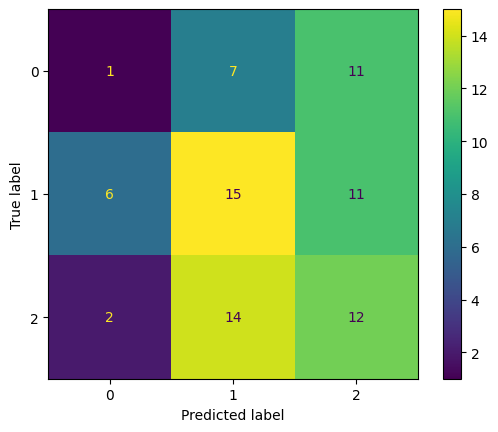

In [54]:
# Random Forest
metrics_display(RandomForestClassifier())


              precision    recall  f1-score   support

           0       0.12      0.11      0.11        19
           1       0.47      0.50      0.48        32
           2       0.48      0.50      0.49        28

    accuracy                           0.41        79
   macro avg       0.36      0.37      0.36        79
weighted avg       0.39      0.41      0.40        79



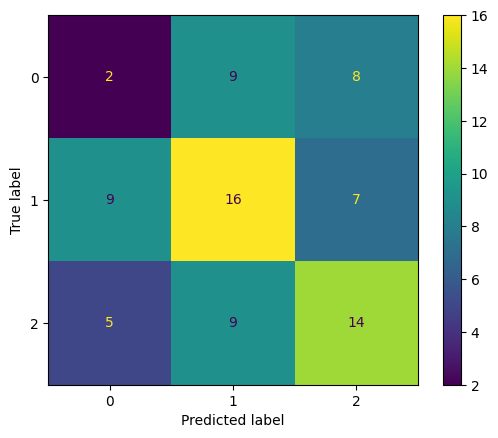

In [55]:
# LogisticRegression
metrics_display(LogisticRegression())

              precision    recall  f1-score   support

           0       0.07      0.05      0.06        19
           1       0.37      0.47      0.41        32
           2       0.43      0.36      0.39        28

    accuracy                           0.33        79
   macro avg       0.29      0.29      0.29        79
weighted avg       0.32      0.33      0.32        79



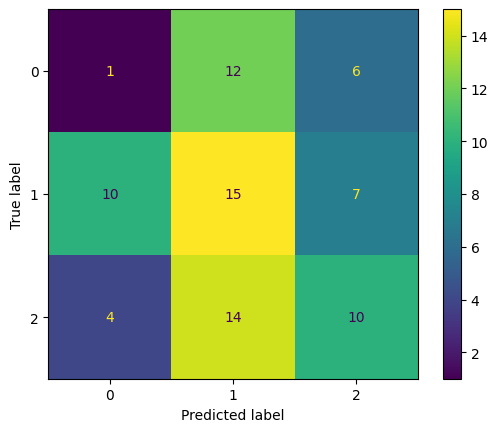

In [56]:
# DecisionTreeClassifier
metrics_display(DecisionTreeClassifier())

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.47      0.59      0.53        32
           2       0.47      0.61      0.53        28

    accuracy                           0.46        79
   macro avg       0.32      0.40      0.35        79
weighted avg       0.36      0.46      0.40        79



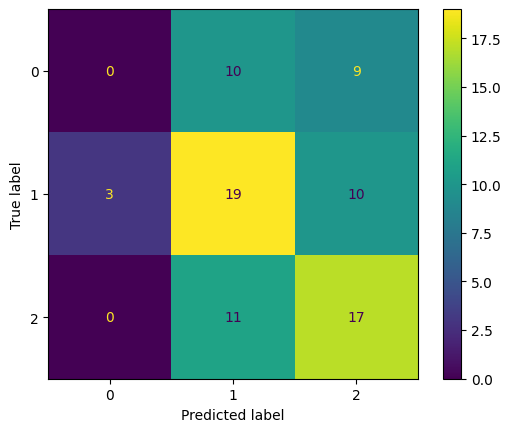

In [57]:
metrics_display(SVC())

LogisticRegression model seems to be doing better, hence will use this.

# Train the Model for the knockout stage (no draw)

In [58]:
# Make a copy of training
training4model2 = training.copy()
training4model2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313 entries, 10 to 50
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   first_team                      313 non-null    object 
 1   second_team                     313 non-null    object 
 2   final_result                    313 non-null    int64  
 3   first_team_Percentage wins      313 non-null    float64
 4   second_team_Percentage wins     313 non-null    float64
 5   first_team_Goal Scored          313 non-null    float64
 6   second_team_Goal Scored         313 non-null    float64
 7   first_team_Goal Conceded        313 non-null    float64
 8   second_team_Goal Conceded       313 non-null    float64
 9   first_team_Rank                 313 non-null    int64  
 10  second_team_Rank                313 non-null    int64  
 11  first_team_Age (mean)           313 non-null    float64
 12  second_team_Age (mean)          313 non-n

In [60]:
#list if the dataframe is balanced
print(training4model2['final_result'].value_counts()[1])
print(training4model2['final_result'].value_counts()[2])


131
116


Without draws, this is going to be a more balanced dataset

In [61]:
#Drop lines with final_result==0
training4model2 = training4model2[training4model2['final_result'] != 0]
training4model2.info()
training4model2.head()

<class 'pandas.core.frame.DataFrame'>
Index: 247 entries, 10 to 50
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   first_team                      247 non-null    object 
 1   second_team                     247 non-null    object 
 2   final_result                    247 non-null    int64  
 3   first_team_Percentage wins      247 non-null    float64
 4   second_team_Percentage wins     247 non-null    float64
 5   first_team_Goal Scored          247 non-null    float64
 6   second_team_Goal Scored         247 non-null    float64
 7   first_team_Goal Conceded        247 non-null    float64
 8   second_team_Goal Conceded       247 non-null    float64
 9   first_team_Rank                 247 non-null    int64  
 10  second_team_Rank                247 non-null    int64  
 11  first_team_Age (mean)           247 non-null    float64
 12  second_team_Age (mean)          247 non-n

,first_team,second_team,final_result,first_team_Percentage wins,second_team_Percentage wins,first_team_Goal Scored,second_team_Goal Scored,first_team_Goal Conceded,second_team_Goal Conceded,first_team_Rank,second_team_Rank,first_team_Age (mean),second_team_Age (mean),first_team_Caps (mean),second_team_Caps (mean),first_team_MarketValue (mean),second_team_MarketValue (mean),first_team_Goals (total),second_team_Goals (total)
10,Poland,Türkiye,1,33.3333,33.3333,1.0278,1.1250,1.1667,1.8750,26,42,27.555556,25.807692,30.555556,24.307692,7.866667e+06,1.246538e+07,154,71
19,Portugal,Croatia,2,61.4035,42.8571,1.7895,1.4762,0.9123,1.4762,6,9,26.961538,27.692308,42.807692,44.307692,4.055769e+07,1.260385e+07,225,147
30,Poland,Ukraine,1,33.3333,36.3636,1.0278,1.1515,1.1667,1.4848,26,24,27.555556,26.346154,30.555556,32.653846,7.866667e+06,1.457692e+07,154,114
46,Austria,Serbia,1,42.8571,55.1724,1.2571,1.8966,1.0286,1.0000,25,32,26.807692,27.384615,23.576923,33.076923,9.057692e+06,1.199231e+07,93,129
61,Germany,Netherlands,1,39.3443,57.4468,1.4262,2.0000,1.3934,1.0638,16,7,28.115385,26.538462,34.846154,32.230769,3.273077e+07,3.250000e+07,134,141


In [197]:
# Separate data and predictions
X_k = training4model2.drop('final_result',axis=1)
y_k = training4model2['final_result']
# Create split
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_k, y_k, test_size=0.25, random_state=42)
#One Hot Encoder
categories_to_encode = ['first_team', 'second_team']
# Create the encoder
encoder = OneHotEncoder()
# Fit only training data
encoder.fit(X_train_k[categories_to_encode])
# Transform both training and test data
X_train_encoded_k = encoder.transform(X_train_k[categories_to_encode])
X_test_encoded_k = encoder.transform(X_test_k[categories_to_encode])
# Create a new DataFrame from the encoded columns
X_train_encoded_df_k = pd.DataFrame(X_train_encoded_k.toarray(), columns=encoder.get_feature_names_out(categories_to_encode))
X_test_encoded_df_k = pd.DataFrame(X_test_encoded_k.toarray(), columns=encoder.get_feature_names_out(categories_to_encode))

# Join the encoded columns with the original DataFrame
X_train_enc_k = pd.concat([X_train_k.drop(categories_to_encode, axis=1).reset_index(drop=True), X_train_encoded_df_k.reset_index(drop=True)], axis=1)
X_test_enc_k = pd.concat([X_test_k.drop(categories_to_encode, axis=1).reset_index(drop=True), X_test_encoded_df_k.reset_index(drop=True)], axis=1)

column_k = X_train_enc_k.columns

# Scale numbers
scaler = StandardScaler()
# train data
X_train_scaled_k = scaler.fit_transform(X_train_enc_k)
# test data
X_test_scaled_k = scaler.transform(X_test_enc_k)
#Convert to Pandas df from numpy array
X_train_scaled_k = pd.DataFrame(X_train_scaled_k, columns = column_k)
X_test_scaled_k = pd.DataFrame(X_test_scaled_k, columns = column_k)


In [64]:
#Create a generic function for testing the models
def metrics_display(model):
    model.fit(X_train_scaled_k,y_train_k)
    y_pred_k = model.predict(X_test_scaled_k)
    print(classification_report(y_test_k,y_pred_k))
    ConfusionMatrixDisplay.from_predictions(y_test_k,y_pred_k);

              precision    recall  f1-score   support

           1       0.53      0.55      0.54        33
           2       0.46      0.45      0.46        29

    accuracy                           0.50        62
   macro avg       0.50      0.50      0.50        62
weighted avg       0.50      0.50      0.50        62



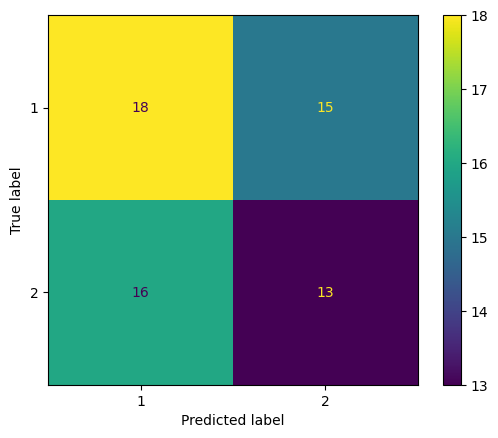

In [65]:
# Random Forest
metrics_display(RandomForestClassifier())

              precision    recall  f1-score   support

           1       0.57      0.61      0.59        33
           2       0.52      0.48      0.50        29

    accuracy                           0.55        62
   macro avg       0.54      0.54      0.54        62
weighted avg       0.55      0.55      0.55        62



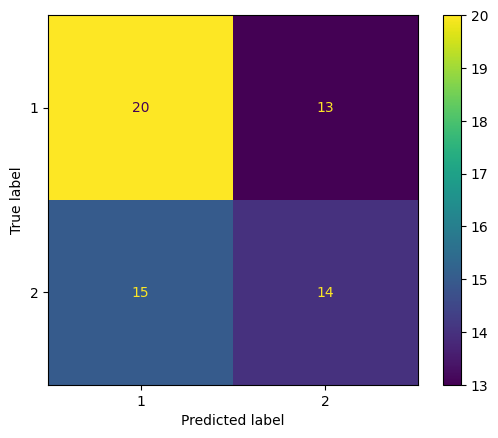

In [66]:
# LogisticRegression
metrics_display(LogisticRegression())

              precision    recall  f1-score   support

           1       0.54      0.58      0.56        33
           2       0.48      0.45      0.46        29

    accuracy                           0.52        62
   macro avg       0.51      0.51      0.51        62
weighted avg       0.51      0.52      0.51        62



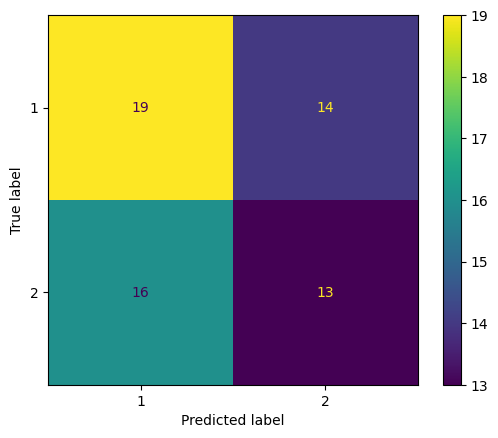

In [67]:
# DecisionTreeClassifier
metrics_display(DecisionTreeClassifier())

              precision    recall  f1-score   support

           1       0.57      0.64      0.60        33
           2       0.52      0.45      0.48        29

    accuracy                           0.55        62
   macro avg       0.54      0.54      0.54        62
weighted avg       0.55      0.55      0.54        62



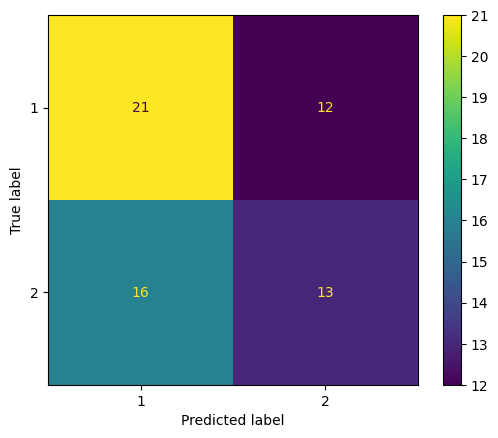

In [68]:
metrics_display(SVC())

Even in this case Logistic regreassion has the best numbers, hence we will use that

# Predict results in group stage

In [69]:
# Groups and points
groups = {"A":['Germany','Switzerland','Hungary','Scotland'],
          "B":['Spain','Italy','Croatia','Albania'],
          "C":['England','Denmark','Slovenia','Serbia'],
          "D":['Austria','France','Netherlands','Poland'],
          "E":['Romania','Belgium','Slovakia','Ukraine'],
          "F":['Portugal','Türkiye','Georgia','Czechia']}

all_teams = {}
Group_A = {}
Group_B = {}
Group_C = {}
Group_D = {}
Group_E = {}
Group_F = {}

Germany = 0
Switzerland = 0
Hungary = 0
Scotland = 0

Spain = 0
Italy = 0
Croatia = 0
Albania = 0

England = 0
Denamark = 0
Slovenia = 0
Serbia = 0

Austria = 0
France = 0
Netherlands = 0
Poland = 0

Romania = 0
Belgium = 0
Slovakia = 0
Ukraine = 0

Portugal = 0
Türkiye = 0
Georgia = 0
Czechia = 0

In [70]:
# copy training dataset into the new one for the score predictions in the group stage
# and drop all rows plus final_result columns to have an empty one
predictions_group_stage = training.copy()
predictions_group_stage.drop(training.index, inplace=True)
# drop 'final_result' column from predictions_group_stage
predictions_group_stage.drop('final_result', axis=1, inplace=True)
predictions_group_stage.head()

,first_team,second_team,first_team_Percentage wins,second_team_Percentage wins,first_team_Goal Scored,second_team_Goal Scored,first_team_Goal Conceded,second_team_Goal Conceded,first_team_Rank,second_team_Rank,first_team_Age (mean),second_team_Age (mean),first_team_Caps (mean),second_team_Caps (mean),first_team_MarketValue (mean),second_team_MarketValue (mean),first_team_Goals (total),second_team_Goals (total)


In [71]:
Group_games = [
               ['Germany', 'Scotland'],['Hungary', 'Switzerland'],['Spain', 'Italy'],['Croatia', 'Albania'], ['Spain', 'Croatia'],
               ['Italy', 'Albania'], ['Poland', 'Netherlands'], ['Slovenia', 'Denmark'], ['England', 'Serbia'], ['Austria', 'France'],
               ['Romania', 'Ukraine'], ['Slovakia', 'Belgium'], ['Türkiye', 'Portugal'], ['Türkiye', 'Georgia'],
               ['Portugal', 'Czechia'], ['Germany', 'Hungary'], ['Scotland', 'Switzerland'], ['Slovenia', 'Serbia'],
               ['Serbia', 'Denmark'], ['Denmark', 'England'], ['Ukraine', 'Slovakia'], ['Poland', 'Austria'], ['Netherlands', 'France'],
               ['Czechia', 'Georgia'], ['Belgium', 'Romania'], ['Switzerland', 'Germany'], ['Scotland', 'Hungary'], ['Albania', 'Spain'],
               ['Slovakia', 'Romania'], ['Ukraine', 'Belgium'], ['Portugal', 'Georgia'], ['Czechia', 'Türkiye'], ['Italy', 'Croatia'],
               ['Netherlands', 'Austria'], ['England', 'Slovenia'], ['France', 'Poland']
               ]

In [72]:
# split 'training' dataset in two so to generate two dataframes with column related only to the first_team and second_team respectively
first_team_df = training[list(training.filter(like='first_team'))]
second_team_df = training[list(training.filter(like='second_team'))]
# Remove Duplicates
first_team_df = first_team_df.drop_duplicates()
second_team_df = second_team_df.drop_duplicates()

In [73]:
# Example output
g0 = first_team_df[first_team_df['first_team'] == 'Italy'].reset_index(drop=True)
g0

,first_team,first_team_Percentage wins,first_team_Goal Scored,first_team_Goal Conceded,first_team_Rank,first_team_Age (mean),first_team_Caps (mean),first_team_MarketValue (mean),first_team_Goals (total)
0,Italy,58.6207,1.2931,0.8103,10,26.5,20.346154,2.713462e+07,59


In [76]:
# Check that there are 18 features
print(predictions_group_stage.columns.shape)
# Again, make sure predictions_group_stage is empty (this might not be true re-running the cells)
predictions_group_stage.drop(predictions_group_stage.index, inplace=True)


(18,)


In [77]:
# Populate predictions_group_stage with values coming from each element of the Group_games list and their corresponding metrics collected in first_team_df and second_team_df

import pandas as pd
for g in Group_games:
  #print(g[0], g[1])
  first_team_df_g = first_team_df[first_team_df['first_team'] == g[0]].reset_index(drop=True)
  second_team_df_g = second_team_df[second_team_df['second_team'] == g[1]].reset_index(drop=True)
  # Create a new row for predictions_group_stage with the values coming from the two dataframes
  new_row = pd.DataFrame([[g[0], g[1],
                           first_team_df_g.iloc[0, 1], second_team_df_g.iloc[0, 1],first_team_df_g.iloc[0, 2],
                           second_team_df_g.iloc[0, 2], first_team_df_g.iloc[0, 3],second_team_df_g.iloc[0, 3],
                           first_team_df_g.iloc[0, 4], second_team_df_g.iloc[0, 4], first_team_df_g.iloc[0, 5],
                           second_team_df_g.iloc[0, 5], first_team_df_g.iloc[0, 6], second_team_df_g.iloc[0, 6],
                           first_team_df_g.iloc[0, 7], second_team_df_g.iloc[0, 7],first_team_df_g.iloc[0, 8],
                           second_team_df_g.iloc[0, 8]]],
                          columns=['first_team', 'second_team', 'first_team_Percentage wins',
       'second_team_Percentage wins', 'first_team_Goal Scored',
       'second_team_Goal Scored', 'first_team_Goal Conceded',
       'second_team_Goal Conceded', 'first_team_Rank', 'second_team_Rank',
       'first_team_Age (mean)', 'second_team_Age (mean)',
       'first_team_Caps (mean)', 'second_team_Caps (mean)',
       'first_team_MarketValue (mean)', 'second_team_MarketValue (mean)',
       'first_team_Goals (total)', 'second_team_Goals (total)'])
  predictions_group_stage = pd.concat([predictions_group_stage, new_row], ignore_index=True)


In [78]:
# Make sure we have a dataframe with 36 rows (games) and 18 features for each game
predictions_group_stage.shape


(36, 18)

In [79]:
predictions_group_stage

,first_team,second_team,first_team_Percentage wins,second_team_Percentage wins,first_team_Goal Scored,second_team_Goal Scored,first_team_Goal Conceded,second_team_Goal Conceded,first_team_Rank,second_team_Rank,first_team_Age (mean),second_team_Age (mean),first_team_Caps (mean),second_team_Caps (mean),first_team_MarketValue (mean),second_team_MarketValue (mean),first_team_Goals (total),second_team_Goals (total)
0,Germany,Scotland,39.3443,39.2857,1.4262,1.3214,1.3934,1.3214,16,39,28.115385,28.230769,34.846154,24.730769,3.273077e+07,7.976923e+06,134,59
1,Hungary,Switzerland,45.7143,34.1463,1.3429,1.3415,1.0286,1.2683,27,19,27.423077,27.692308,28.846154,42.000000,6.325000e+06,1.084615e+07,60,125
2,Spain,Italy,63.6364,58.6207,1.9818,1.2931,0.8364,0.8103,8,10,26.961538,26.500000,20.576923,20.346154,3.713462e+07,2.713462e+07,95,59
3,Croatia,Albania,42.8571,31.0345,1.4762,0.9310,1.4762,1.1379,9,66,27.692308,27.307692,44.307692,26.115385,1.260385e+07,4.292308e+06,147,40
4,Spain,Croatia,63.6364,42.8571,1.9818,1.4762,0.8364,1.4762,8,9,26.961538,27.692308,20.576923,44.307692,3.713462e+07,1.260385e+07,95,147
5,Italy,Albania,58.6207,31.0345,1.2931,0.9310,0.8103,1.1379,10,66,26.500000,27.307692,20.346154,26.115385,2.713462e+07,4.292308e+06,59,40
6,Poland,Netherlands,33.3333,57.4468,1.0278,2.0000,1.1667,1.0638,26,7,27.555556,26.538462,30.555556,32.230769,7.866667e+06,3.250000e+07,154,141
7,Slovenia,Denmark,32.1429,47.3684,1.1786,1.3947,1.0000,1.1579,57,21,27.346154,27.692308,29.653846,41.192308,5.365385e+06,1.598077e+07,78,135
8,England,Serbia,45.8333,55.1724,1.3958,1.8966,1.0208,1.0000,5,32,26.076923,27.384615,25.038462,33.076923,5.826923e+07,1.199231e+07,100,129
9,Austria,France,42.8571,53.7037,1.2571,1.6296,1.0286,1.1296,25,2,26.807692,26.880000,23.576923,33.440000,9.057692e+06,4.936000e+07,93,192


If now we call predict on predictions_group_stage we will get a 'value error'.

In fact every model we trained (e.g. LogisticRegression) was trained on a dataset (X_train_scaled) with specific feature names (like 'first_team_Albania', etc.).

However, when you're trying to predict using the predictions_group_stage DataFrame, it has different feature names ('first_team', 'second_team')

So what we needs to do next is encode our data in the same way we did with X_train_scaled


In [80]:
#One Hot Encoder
categories_to_encode = ['first_team', 'second_team']
# Create the encoder
encoder = OneHotEncoder()
# Fit
encoder.fit(predictions_group_stage[categories_to_encode])
# Transform
predictions_group_stage_encoded = encoder.transform(predictions_group_stage[categories_to_encode])
# Create a new DataFrame from the encoded columns
predictions_group_stage_encoded_df = pd.DataFrame(predictions_group_stage_encoded.toarray(), columns=encoder.get_feature_names_out(categories_to_encode))

# Join the encoded columns with the original DataFrame
predictions_group_stage_enc = pd.concat([predictions_group_stage.drop(categories_to_encode, axis=1).reset_index(drop=True), predictions_group_stage_encoded_df.reset_index(drop=True)], axis=1)

column_k = predictions_group_stage_enc.columns

# Scale numbers
scaler = StandardScaler()
# train data
predictions_group_stage_enc_scaled = scaler.fit_transform(predictions_group_stage_enc)
#Convert to Pandas df from numpy array
predictions_group_stage_scaled = pd.DataFrame(predictions_group_stage_enc_scaled, columns = column_k)
predictions_group_stage_scaled.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 63 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   first_team_Percentage wins      36 non-null     float64
 1   second_team_Percentage wins     36 non-null     float64
 2   first_team_Goal Scored          36 non-null     float64
 3   second_team_Goal Scored         36 non-null     float64
 4   first_team_Goal Conceded        36 non-null     float64
 5   second_team_Goal Conceded       36 non-null     float64
 6   first_team_Rank                 36 non-null     float64
 7   second_team_Rank                36 non-null     float64
 8   first_team_Age (mean)           36 non-null     float64
 9   second_team_Age (mean)          36 non-null     float64
 10  first_team_Caps (mean)          36 non-null     float64
 11  second_team_Caps (mean)         36 non-null     float64
 12  first_team_MarketValue (mean)   36 non

In [81]:
# Make sure all_teams is empty at this point
def create_dict():
  global my_dict
  if 'all_teams' not in globals():
    all_teams = {}

create_dict()

In [190]:
# Make sure all_teams is empty at this point
all_teams = {}
# Run games in the Group Stage
def run_group_games(model):
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(predictions_group_stage_scaled)
    #print(y_pred)
    #print(len(y_pred))
    print("GROUP GAMES RESULTS")
    print("---------------------")
    for g in range(len(Group_games)):
      print(Group_games[g][0] + ' vs ' + Group_games[g][1])
      if y_pred[g] == 1:
           print(Group_games[g][0] + ' wins')
           all_teams[Group_games[g][0]] = all_teams.get(Group_games[g][0],0) + 3
           all_teams[Group_games[g][1]] = all_teams.get(Group_games[g][1],0) + 0
      elif y_pred[g] == 2:
           print(Group_games[g][1] + ' wins')
           all_teams[Group_games[g][0]] = all_teams.get(Group_games[g][0],0) + 0
           all_teams[Group_games[g][1]] = all_teams.get(Group_games[g][1],0) + 3

      else:
           print("It's a draw!")
           all_teams[Group_games[g][0]] = all_teams.get(Group_games[g][0],0) + 1
           all_teams[Group_games[g][1]] = all_teams.get(Group_games[g][1],0) + 1
      print('---------------------')

    print("POINTS AWARDED TO EACH TEAM")
    for k,v in all_teams.items():
      print(k+" : "+ str(v) +" points")

    print(all_teams)

# Group Games Showtime

In [83]:
run_group_games(DecisionTreeClassifier())

GROUP GAMES RESULTS
---------------------
Germany vs Scotland
It's a draw!
---------------------
Hungary vs Switzerland
Hungary wins
---------------------
Spain vs Italy
Spain wins
---------------------
Croatia vs Albania
It's a draw!
---------------------
Spain vs Croatia
Spain wins
---------------------
Italy vs Albania
Italy wins
---------------------
Poland vs Netherlands
Netherlands wins
---------------------
Slovenia vs Denmark
Slovenia wins
---------------------
England vs Serbia
Serbia wins
---------------------
Austria vs France
It's a draw!
---------------------
Romania vs Ukraine
Romania wins
---------------------
Slovakia vs Belgium
Belgium wins
---------------------
Türkiye vs Portugal
Portugal wins
---------------------
Türkiye vs Georgia
Türkiye wins
---------------------
Portugal vs Czechia
Portugal wins
---------------------
Germany vs Hungary
It's a draw!
---------------------
Scotland vs Switzerland
It's a draw!
---------------------
Slovenia vs Serbia
Slovenia wins


In [114]:
groups = {"A":['Germany','Switzerland','Hungary','Scotland'],
          "B":['Spain','Italy','Croatia','Albania'],
          "C":['England','Denmark','Slovenia','Serbia'],
          "D":['Austria','France','Netherlands','Poland'],
          "E":['Romania','Belgium','Slovakia','Ukraine'],
          "F":['Portugal','Türkiye','Georgia','Czechia']}

Group_A = {}
Group_B = {}
Group_C = {}
Group_D = {}
Group_E = {}
Group_F = {}

roster_knockout = {}

In [175]:
for team, points in all_teams.items():
  if team in groups['A']:
    Group_A[team] = points
  elif team in groups['B']:
    Group_B[team] = points
  elif team in groups['C']:
    Group_C[team] = points
  elif team in groups['D']:
    Group_D[team] = points
  elif team in groups['E']:
    Group_E[team] = points
  elif team in groups['F']:
    Group_F[team] = points

# Sort
Group_A_sort = sorted(Group_A.items(), key=lambda x: x[1], reverse=True)
Group_B_sort = sorted(Group_B.items(), key=lambda x: x[1], reverse=True)
Group_C_sort = sorted(Group_C.items(), key=lambda x: x[1], reverse=True)
Group_D_sort = sorted(Group_D.items(), key=lambda x: x[1], reverse=True)
Group_E_sort = sorted(Group_E.items(), key=lambda x: x[1], reverse=True)
Group_F_sort = sorted(Group_F.items(), key=lambda x: x[1], reverse=True)

#Publish
print("Group A final results: ")
print(Group_A_sort)
print("")
print("Group B final results: ")
print(Group_B_sort)
print("")
print("Group C final results: ")
print(Group_C_sort)
print("")
print("Group D final results: ")
print(Group_D_sort)
print("")
print("Group E final results: ")
print(Group_E_sort)
print("")
print("Group F final results: ")
print(Group_F_sort)
print("")
#Qualified
print("TEAMS DIRECTLY QUALIFIED FOR THE ROUND OF 16")
print("============================================")

roster_knockout['A1']=Group_A_sort[0][0]
roster_knockout['A2']=Group_A_sort[1][0]

roster_knockout['B1']=Group_B_sort[0][0]
roster_knockout['B2']=Group_B_sort[1][0]

roster_knockout['C1']=Group_C_sort[0][0]
roster_knockout['C2']=Group_C_sort[1][0]

roster_knockout['D1']=Group_D_sort[0][0]
roster_knockout['D2']=Group_D_sort[1][0]

roster_knockout['E1']=Group_E_sort[0][0]
roster_knockout['E2']=Group_E_sort[1][0]

roster_knockout['F1']=Group_F_sort[0][0]
roster_knockout['F2']=Group_F_sort[1][0]

print(Group_A_sort[0][0])
print(Group_A_sort[1][0])
print(Group_B_sort[0][0])
print(Group_B_sort[1][0])
print(Group_C_sort[0][0])
print(Group_C_sort[1][0])
print(Group_D_sort[0][0])
print(Group_D_sort[1][0])
print(Group_E_sort[0][0])
print(Group_E_sort[1][0])
print(Group_F_sort[0][0])
print(Group_F_sort[1][0])
print(roster_knockout)
print("")

#Top four third
rescued = []
rescued_teams = {}

rescued.append(Group_A_sort[2])
rescued.append(Group_B_sort[2])
rescued.append(Group_C_sort[2])
rescued.append(Group_D_sort[2])
rescued.append(Group_E_sort[2])
rescued.append(Group_F_sort[2])

print("The Four Best Third")
print("=========================")
rescued_1 = sorted(rescued, key=lambda x: x[1], reverse=True)[0]
print(rescued_1[0])
rescued_2 = sorted(rescued, key=lambda x: x[1], reverse=True)[1]
print(rescued_2[0])
rescued_3 = sorted(rescued, key=lambda x: x[1], reverse=True)[2]
print(rescued_3[0])
rescued_4 = sorted(rescued, key=lambda x: x[1], reverse=True)[3]
print(rescued_4[0])

for rescued_third in [rescued_1[0], rescued_2[0], rescued_3[0], rescued_4[0]]:
  if rescued_third in groups['A']:
     #roster_knockout['A3']=Group_A_sort[2][0]
     rescued_teams['A']=Group_A_sort[2][0]
  elif rescued_third in groups['B']:
     #roster_knockout['B3']=Group_B_sort[2][0]
     rescued_teams['B']=Group_B_sort[2][0]
  elif rescued_third in groups['C']:
     #roster_knockout['C3']=Group_C_sort[2][0]
     rescued_teams['C']=Group_C_sort[2][0]
  elif rescued_third in groups['D']:
     #roster_knockout['D3']=Group_D_sort[2][0]
     rescued_teams['D']=Group_D_sort[2][0]
  elif rescued_third in groups['E']:
     #roster_knockout['E3']=Group_E_sort[2][0]
     rescued_teams['E']=Group_E_sort[2][0]
  elif rescued_third in groups['F']:
     #roster_knockout['F3']=Group_F_sort[2][0]
     rescued_teams['F']=Group_F_sort[2][0]

#print(roster_knockout)
print(rescued_teams)


Group A final results: 
[('Scotland', 5), ('Hungary', 4), ('Switzerland', 4), ('Germany', 2)]

Group B final results: 
[('Spain', 9), ('Italy', 6), ('Croatia', 1), ('Albania', 1)]

Group C final results: 
[('Slovenia', 9), ('Serbia', 6), ('Denmark', 3), ('England', 0)]

Group D final results: 
[('Netherlands', 9), ('Austria', 4), ('France', 2), ('Poland', 1)]

Group E final results: 
[('Romania', 6), ('Ukraine', 6), ('Belgium', 6), ('Slovakia', 0)]

Group F final results: 
[('Türkiye', 6), ('Portugal', 6), ('Georgia', 3), ('Czechia', 3)]

TEAMS DIRECTLY QUALIFIED FOR THE ROUND OF 16
Scotland
Hungary
Spain
Italy
Slovenia
Serbia
Netherlands
Austria
Romania
Ukraine
Türkiye
Portugal
{'A1': 'Scotland', 'A2': 'Hungary', 'B1': 'Spain', 'B2': 'Italy', 'C1': 'Slovenia', 'C2': 'Serbia', 'D1': 'Netherlands', 'D2': 'Austria', 'E1': 'Romania', 'E2': 'Ukraine', 'F1': 'Türkiye', 'F2': 'Portugal'}

The Four Best Third
Belgium
Switzerland
Denmark
Georgia
{'E': 'Belgium', 'A': 'Switzerland', 'C': 'Denma

# Roster for Round of 16

In [176]:
# Frequency of groups in the rescued team roster
# 'A': 3
# 'D': 3
# 'B': 2
# 'C': 2
# 'E': 2
# 'F': 2
# Will assign first best third in 'A' and 'D', if any

# Clear the est third names to have a complete roster

ABCD = ""
if 'A' in rescued_teams:
  ABCD = rescued_teams['A']
  rescued_teams.pop('A')
elif 'B' in rescued_teams:
  ABCD = rescued_teams['B']
  rescued_teams.pop('B')
elif 'C' in rescued_teams:
  ABCD = rescued_teams['C']
  rescued_teams.pop('C')
elif 'D' in rescued_teams:
  ADEF = rescued_teams['D']
  rescued_teams.pop('D')

print(ABCD)
#print(rescued_teams)

ADEF = ''
if 'A' in rescued_teams:
  ADEF = rescued_teams['A']
  rescued_teams.pop('A')
elif 'D' in rescued_teams:
  ADEF = rescued_teams['D']
  rescued_teams.pop('D')
elif 'E' in rescued_teams:
  ADEF = rescued_teams['E']
  rescued_teams.pop('E')
elif 'F' in rescued_teams:
  ADEF = rescued_teams['F']
  rescued_teams.pop('F')

print(ADEF)
#print(rescued_teams)

ABC = ''
if 'A' in rescued_teams:
  ABC = rescued_teams['A']
  rescued_teams.pop('A')
elif 'B' in rescued_teams:
  ABC = rescued_teams['B']
  rescued_teams.pop('B')
elif 'C' in rescued_teams:
  ABC = rescued_teams['C']
  rescued_teams.pop('C')

print(ABC)
#print(rescued_teams)

#only left one value
for k,v in rescued_teams.items():
  DEF=v
print(DEF)

rescued_teams_final = {'ABCD':ABCD, 'ADEF':ADEF, 'ABC':ABC, 'DEF':DEF}

Switzerland
Belgium
Denmark
Georgia


In [177]:
# Final group of teams for the round of 16
print(roster_knockout)
print(rescued_teams_final)


{'A1': 'Scotland', 'A2': 'Hungary', 'B1': 'Spain', 'B2': 'Italy', 'C1': 'Slovenia', 'C2': 'Serbia', 'D1': 'Netherlands', 'D2': 'Austria', 'E1': 'Romania', 'E2': 'Ukraine', 'F1': 'Türkiye', 'F2': 'Portugal'}
{'ABCD': 'Switzerland', 'ADEF': 'Belgium', 'ABC': 'Denmark', 'DEF': 'Georgia'}


# Predictions for the round of 16

In [255]:
# From https://library.sportingnews.com/downloads/euros/2024/Euros-2024-printable-bracket-schedule-US-times.pdf?

# Left side
# B1-ADEF \
# A1-C2   /     __
# F1-ABC  \
# D2-E2   /

# Right side
# E1-ABCD \
# D1-F2.  /     __
# C1-DEF  \
# A2-B2   /

round_of_sixteen = pd.DataFrame({'First_team': [roster_knockout['B1'], roster_knockout['A1'], roster_knockout['F1'],roster_knockout['D2'],roster_knockout['E1'],roster_knockout['D1'],
                                                roster_knockout['C1'], roster_knockout['A2']], 'Second_team': [rescued_teams_final['ADEF'], roster_knockout['C2'], rescued_teams_final['ABC'],
                                                                                                               roster_knockout['E2'], rescued_teams_final['ABCD'],roster_knockout['F2'],
                                                                                                               rescued_teams_final['DEF'], roster_knockout['B2']]})
round_of_sixteen_list = round_of_sixteen.values.tolist()
print(round_of_sixteen_list)


[['Spain', 'Belgium'], ['Scotland', 'Serbia'], ['Türkiye', 'Denmark'], ['Austria', 'Ukraine'], ['Romania', 'Switzerland'], ['Netherlands', 'Portugal'], ['Slovenia', 'Georgia'], ['Hungary', 'Italy']]


In [256]:
# Populate round_of_sixteen with values coming from each element of the round_of_sixteen_list list and their corresponding metrics collected in first_team_df and second_team_df
# Note to self, this could be a function defined at the beginning that takes round_of_sixteen_list as argument and spit out the updated dataframe
import pandas as pd
round_of_sixteen_final = pd.DataFrame()

for g in round_of_sixteen_list:
  #print(g[0], g[1])
  first_team_df_g_r16 = first_team_df[first_team_df['first_team'] == g[0]].reset_index(drop=True)
  second_team_df_g_r16 = second_team_df[second_team_df['second_team'] == g[1]].reset_index(drop=True)
  # Create a new row for predictions_group_stage with the values coming from the two dataframes
  new_row = pd.DataFrame([[g[0], g[1],
                           first_team_df_g_r16.iloc[0, 1], second_team_df_g_r16.iloc[0, 1],first_team_df_g_r16.iloc[0, 2],
                           second_team_df_g_r16.iloc[0, 2], first_team_df_g_r16.iloc[0, 3],second_team_df_g_r16.iloc[0, 3],
                           first_team_df_g_r16.iloc[0, 4], second_team_df_g_r16.iloc[0, 4], first_team_df_g_r16.iloc[0, 5],
                           second_team_df_g_r16.iloc[0, 5], first_team_df_g_r16.iloc[0, 6], second_team_df_g_r16.iloc[0, 6],
                           first_team_df_g_r16.iloc[0, 7], second_team_df_g_r16.iloc[0, 7],first_team_df_g_r16.iloc[0, 8],
                           second_team_df_g_r16.iloc[0, 8]]],
                          columns=['first_team', 'second_team', 'first_team_Percentage wins',
       'second_team_Percentage wins', 'first_team_Goal Scored',
       'second_team_Goal Scored', 'first_team_Goal Conceded',
       'second_team_Goal Conceded', 'first_team_Rank', 'second_team_Rank',
       'first_team_Age (mean)', 'second_team_Age (mean)',
       'first_team_Caps (mean)', 'second_team_Caps (mean)',
       'first_team_MarketValue (mean)', 'second_team_MarketValue (mean)',
       'first_team_Goals (total)', 'second_team_Goals (total)'])
  round_of_sixteen_final = pd.concat([round_of_sixteen_final, new_row], ignore_index=True)

In [257]:
round_of_sixteen_final

,first_team,second_team,first_team_Percentage wins,second_team_Percentage wins,first_team_Goal Scored,second_team_Goal Scored,first_team_Goal Conceded,second_team_Goal Conceded,first_team_Rank,second_team_Rank,first_team_Age (mean),second_team_Age (mean),first_team_Caps (mean),second_team_Caps (mean),first_team_MarketValue (mean),second_team_MarketValue (mean),first_team_Goals (total),second_team_Goals (total)
0,Spain,Belgium,63.6364,60.0000,1.9818,1.9000,0.8364,1.1500,8,3,26.961538,26.880000,20.576923,37.960000,3.713462e+07,2.338000e+07,95,177
1,Scotland,Serbia,39.2857,55.1724,1.3214,1.8966,1.3214,1.0000,39,32,28.230769,27.384615,24.730769,33.076923,7.976923e+06,1.199231e+07,59,129
2,Türkiye,Denmark,33.3333,47.3684,1.1250,1.3947,1.8750,1.1579,42,21,25.807692,27.692308,24.307692,41.192308,1.246538e+07,1.598077e+07,71,135
3,Austria,Ukraine,42.8571,36.3636,1.2571,1.1515,1.0286,1.4848,25,24,26.807692,26.346154,23.576923,32.653846,9.057692e+06,1.457692e+07,93,114
4,Romania,Switzerland,25.0000,34.1463,1.1111,1.3415,1.1667,1.2683,47,19,27.000000,27.692308,22.692308,42.000000,3.543269e+06,1.084615e+07,63,125
5,Netherlands,Portugal,57.4468,61.4035,2.0000,1.7895,1.0638,0.9123,7,6,26.538462,26.961538,32.230769,42.807692,3.250000e+07,4.055769e+07,141,225
6,Slovenia,Georgia,32.1429,61.5385,1.1786,2.0769,1.0000,0.7692,57,74,27.346154,27.153846,29.653846,28.846154,5.365385e+06,6.159615e+06,78,64
7,Hungary,Italy,45.7143,58.6207,1.3429,1.2931,1.0286,0.8103,27,10,27.423077,26.500000,28.846154,20.346154,6.325000e+06,2.713462e+07,60,59


In [259]:
# concat X_train and round_of_sixteen_final
round_of_sixteen_enhanced = pd.concat([round_of_sixteen_final,X], ignore_index=True)
round_of_sixteen_enhanced.head(8)

,first_team,second_team,first_team_Percentage wins,second_team_Percentage wins,first_team_Goal Scored,second_team_Goal Scored,first_team_Goal Conceded,second_team_Goal Conceded,first_team_Rank,second_team_Rank,first_team_Age (mean),second_team_Age (mean),first_team_Caps (mean),second_team_Caps (mean),first_team_MarketValue (mean),second_team_MarketValue (mean),first_team_Goals (total),second_team_Goals (total)
0,Spain,Belgium,63.6364,60.0000,1.9818,1.9000,0.8364,1.1500,8,3,26.961538,26.880000,20.576923,37.960000,3.713462e+07,2.338000e+07,95,177
1,Scotland,Serbia,39.2857,55.1724,1.3214,1.8966,1.3214,1.0000,39,32,28.230769,27.384615,24.730769,33.076923,7.976923e+06,1.199231e+07,59,129
2,Türkiye,Denmark,33.3333,47.3684,1.1250,1.3947,1.8750,1.1579,42,21,25.807692,27.692308,24.307692,41.192308,1.246538e+07,1.598077e+07,71,135
3,Austria,Ukraine,42.8571,36.3636,1.2571,1.1515,1.0286,1.4848,25,24,26.807692,26.346154,23.576923,32.653846,9.057692e+06,1.457692e+07,93,114
4,Romania,Switzerland,25.0000,34.1463,1.1111,1.3415,1.1667,1.2683,47,19,27.000000,27.692308,22.692308,42.000000,3.543269e+06,1.084615e+07,63,125
5,Netherlands,Portugal,57.4468,61.4035,2.0000,1.7895,1.0638,0.9123,7,6,26.538462,26.961538,32.230769,42.807692,3.250000e+07,4.055769e+07,141,225
6,Slovenia,Georgia,32.1429,61.5385,1.1786,2.0769,1.0000,0.7692,57,74,27.346154,27.153846,29.653846,28.846154,5.365385e+06,6.159615e+06,78,64
7,Hungary,Italy,45.7143,58.6207,1.3429,1.2931,1.0286,0.8103,27,10,27.423077,26.500000,28.846154,20.346154,6.325000e+06,2.713462e+07,60,59


In [260]:
#One Hot Encoder
categories_to_encode = ['first_team', 'second_team']
# Create the encoder
encoder = OneHotEncoder()
# Fit
encoder.fit(round_of_sixteen_enhanced[categories_to_encode])
# Transform
round_of_sixteen_final_encoded = encoder.transform(round_of_sixteen_enhanced[categories_to_encode])
# Create a new DataFrame from the encoded columns
round_of_sixteen_final_encoded_df = pd.DataFrame(round_of_sixteen_final_encoded.toarray(), columns=encoder.get_feature_names_out(categories_to_encode))

# Join the encoded columns with the original DataFrame
round_of_sixteen_final_enc = pd.concat([round_of_sixteen_enhanced.drop(categories_to_encode, axis=1).reset_index(drop=True), round_of_sixteen_final_encoded_df.reset_index(drop=True)], axis=1)

column_k = round_of_sixteen_final_enc.columns

# Scale numbers
scaler = StandardScaler()
# train data
round_of_sixteen_final_enc_scaled = scaler.fit_transform(round_of_sixteen_final_enc)
#Convert to Pandas df from numpy array
round_of_sixteen_scaled = pd.DataFrame(round_of_sixteen_final_enc_scaled, columns = column_k)
#round_of_sixteen_scaled.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 63 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   first_team_Percentage wins      321 non-null    float64
 1   second_team_Percentage wins     321 non-null    float64
 2   first_team_Goal Scored          321 non-null    float64
 3   second_team_Goal Scored         321 non-null    float64
 4   first_team_Goal Conceded        321 non-null    float64
 5   second_team_Goal Conceded       321 non-null    float64
 6   first_team_Rank                 321 non-null    float64
 7   second_team_Rank                321 non-null    float64
 8   first_team_Age (mean)           321 non-null    float64
 9   second_team_Age (mean)          321 non-null    float64
 10  first_team_Caps (mean)          321 non-null    float64
 11  second_team_Caps (mean)         321 non-null    float64
 12  first_team_MarketValue (mean)   321 

In [263]:
# Run games in the round of Sixteen
# used X_train_scaled for training
# Not using the train/test split for avoiding draws, as it caused missing values

def run_round_of_sixteen_games(model):
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(round_of_sixteen_scaled)
    #print(y_pred)
    #print(len(y_pred))
    print("Round of Sixteen Results")
    print("---------------------")
    for g in range(8):
      # Handling Draws: if two team draws during regular times then penalty kicks lottery is unpredictable
      # To draw a line (and until I figure out a better way), the highest ranking (lowest value) will be used
      # To determine the winner
      print(round_of_sixteen_list[g][0] + ' vs ' + round_of_sixteen_list[g][1])
      if y_pred[g] == 0:
           first_team_rank=fifa_euro_ranking.loc[fifa_euro_ranking['Team'] == round_of_sixteen_list[g][0]]['Rank'].values[0]
           second_team_rank=fifa_euro_ranking.loc[fifa_euro_ranking['Team'] == round_of_sixteen_list[g][1]]['Rank'].values[0]
           if first_team_rank < second_team_rank:
              print(round_of_sixteen_list[g][0] + ' Advances after penalty kicks')
           else:
              print(round_of_sixteen_list[g][1] + ' Advances after penalty kicks')
      elif y_pred[g] == 1:
           print(round_of_sixteen_list[g][0] + ' Advances')
      elif y_pred[g] == 2:
           print(round_of_sixteen_list[g][1] + ' Advances')
      print('---------------------')

# Round of Sixteen SHOWTIME

In [265]:
run_round_of_sixteen_games(LogisticRegression())

Round of Sixteen Results
---------------------
Spain vs Belgium
Spain Advances
---------------------
Scotland vs Serbia
Scotland Advances
---------------------
Türkiye vs Denmark
Denmark Advances
---------------------
Austria vs Ukraine
Austria Advances
---------------------
Romania vs Switzerland
Switzerland Advances after penalty kicks
---------------------
Netherlands vs Portugal
Portugal Advances
---------------------
Slovenia vs Georgia
Slovenia Advances after penalty kicks
---------------------
Hungary vs Italy
Italy Advances
---------------------


## Roster for Round of eight

In [268]:
# The torunament is developing through two tracks:
Left_side_round_of_eigth = [['Spain','Scotland'],['Denmark','Austria']]
Right_side_round_of_eigth = [['Switzerland','Portugal'],['Slovenia','Italy']]

# For convenience, we work on one list
round_of_eight_list = Left_side_round_of_eigth + Right_side_round_of_eigth
print(round_of_eight_list)

[['Spain', 'Scotland'], ['Denmark', 'Austria'], ['Switzerland', 'Portugal'], ['Slovenia', 'Italy']]


# Round of Eight

In [270]:
# Populate round_of_eight with values coming from each element of the round_of_eight_list list and their corresponding metrics collected in first_team_df and second_team_df
# Note to self, this could be a function defined at the beginning that takes round_of_sixteen_list as argument and spit out the updated dataframe
import pandas as pd
round_of_eight_final = pd.DataFrame()

for g in round_of_eight_list:
  #print(g[0], g[1])
  first_team_df_g_r8 = first_team_df[first_team_df['first_team'] == g[0]].reset_index(drop=True)
  second_team_df_g_r8 = second_team_df[second_team_df['second_team'] == g[1]].reset_index(drop=True)
  # Create a new row for predictions_group_stage with the values coming from the two dataframes
  new_row = pd.DataFrame([[g[0], g[1],
                           first_team_df_g_r8.iloc[0, 1], second_team_df_g_r8.iloc[0, 1],first_team_df_g_r8.iloc[0, 2],
                           second_team_df_g_r8.iloc[0, 2], first_team_df_g_r8.iloc[0, 3],second_team_df_g_r8.iloc[0, 3],
                           first_team_df_g_r8.iloc[0, 4], second_team_df_g_r8.iloc[0, 4], first_team_df_g_r8.iloc[0, 5],
                           second_team_df_g_r8.iloc[0, 5], first_team_df_g_r8.iloc[0, 6], second_team_df_g_r8.iloc[0, 6],
                           first_team_df_g_r8.iloc[0, 7], second_team_df_g_r8.iloc[0, 7],first_team_df_g_r8.iloc[0, 8],
                           second_team_df_g_r8.iloc[0, 8]]],
                          columns=['first_team', 'second_team', 'first_team_Percentage wins',
       'second_team_Percentage wins', 'first_team_Goal Scored',
       'second_team_Goal Scored', 'first_team_Goal Conceded',
       'second_team_Goal Conceded', 'first_team_Rank', 'second_team_Rank',
       'first_team_Age (mean)', 'second_team_Age (mean)',
       'first_team_Caps (mean)', 'second_team_Caps (mean)',
       'first_team_MarketValue (mean)', 'second_team_MarketValue (mean)',
       'first_team_Goals (total)', 'second_team_Goals (total)'])
  round_of_eight_final = pd.concat([round_of_eight_final, new_row], ignore_index=True)

In [271]:
round_of_eight_final

,first_team,second_team,first_team_Percentage wins,second_team_Percentage wins,first_team_Goal Scored,second_team_Goal Scored,first_team_Goal Conceded,second_team_Goal Conceded,first_team_Rank,second_team_Rank,first_team_Age (mean),second_team_Age (mean),first_team_Caps (mean),second_team_Caps (mean),first_team_MarketValue (mean),second_team_MarketValue (mean),first_team_Goals (total),second_team_Goals (total)
0,Spain,Scotland,63.6364,39.2857,1.9818,1.3214,0.8364,1.3214,8,39,26.961538,28.230769,20.576923,24.730769,3.713462e+07,7.976923e+06,95,59
1,Denmark,Austria,47.3684,42.8571,1.3947,1.2571,1.1579,1.0286,21,25,27.692308,26.807692,41.192308,23.576923,1.598077e+07,9.057692e+06,135,93
2,Switzerland,Portugal,34.1463,61.4035,1.3415,1.7895,1.2683,0.9123,19,6,27.692308,26.961538,42.000000,42.807692,1.084615e+07,4.055769e+07,125,225
3,Slovenia,Italy,32.1429,58.6207,1.1786,1.2931,1.0000,0.8103,57,10,27.346154,26.500000,29.653846,20.346154,5.365385e+06,2.713462e+07,78,59


In [283]:
# concat X and round_of_eight_final
round_of_eight_enhanced = pd.concat([round_of_eight_final,X], ignore_index=True)
round_of_eight_enhanced.head(4)
result_round_of_eight = []

In [284]:
#One Hot Encoder
categories_to_encode = ['first_team', 'second_team']
# Create the encoder
encoder = OneHotEncoder()
# Fit
encoder.fit(round_of_eight_enhanced[categories_to_encode])
# Transform
round_of_eight_final_encoded = encoder.transform(round_of_eight_enhanced[categories_to_encode])
# Create a new DataFrame from the encoded columns
round_of_eight_final_encoded_df = pd.DataFrame(round_of_eight_final_encoded.toarray(), columns=encoder.get_feature_names_out(categories_to_encode))

# Join the encoded columns with the original DataFrame
round_of_eight_final_enc = pd.concat([round_of_eight_enhanced.drop(categories_to_encode, axis=1).reset_index(drop=True), round_of_eight_final_encoded_df.reset_index(drop=True)], axis=1)
column_k = round_of_eight_final_enc.columns

# Scale numbers
scaler = StandardScaler()
# train data
round_of_eight_final_enc_scaled = scaler.fit_transform(round_of_eight_final_enc)
#Convert to Pandas df from numpy array
round_of_eight_scaled = pd.DataFrame(round_of_eight_final_enc_scaled, columns = column_k)
#round_of_sixteen_scaled.info()

In [287]:
# Run games in the round of Eight
# used X_train_scaled for training
# Not using the train/test split for avoiding draws, as it caused missing values
result_round_of_eight = []
def run_round_of_eight_games(model):
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(round_of_eight_scaled)
    print("Round of Eight Results")
    print("---------------------")
    for g in range(4):
      # Handling Draws: if two team draws during regular times then penalty kicks lottery is unpredictable
      # To draw a line (and until I figure out a better way), the highest ranking (lowest value) will be used
      # To determine the winner
      print(round_of_eight_list[g][0] + ' vs ' + round_of_eight_list[g][1])
      if y_pred[g] == 0:
           first_team_rank=fifa_euro_ranking.loc[fifa_euro_ranking['Team'] == round_of_eight_list[g][0]]['Rank'].values[0]
           second_team_rank=fifa_euro_ranking.loc[fifa_euro_ranking['Team'] == round_of_eight_list[g][1]]['Rank'].values[0]
           if first_team_rank < second_team_rank:
              print(round_of_eight_list[g][0] + ' Advances after penalty kicks')
              result_round_of_eight.append(round_of_eight_list[g][0])
           else:
              print(round_of_eight_list[g][1] + ' Advances after penalty kicks')
              result_round_of_eight.append(round_of_eight_list[g][1])
      elif y_pred[g] == 1:
           print(round_of_eight_list[g][0] + ' Advances')
           result_round_of_eight.append(round_of_eight_list[g][0])
      elif y_pred[g] == 2:
           print(round_of_eight_list[g][1] + ' Advances')
           result_round_of_eight.append(round_of_eight_list[g][1])
      print('---------------------')

# Round of Four Showtime


In [298]:
run_round_of_eight_games(LogisticRegression())
result_round_of_eight

Round of Eight Results
---------------------
Spain vs Scotland
Spain Advances
---------------------
Denmark vs Austria
Austria Advances
---------------------
Switzerland vs Portugal
Portugal Advances
---------------------
Slovenia vs Italy
Italy Advances
---------------------


['Spain', 'Austria', 'Portugal', 'Italy']

## Roaster for semifinals

In [290]:
semi_finals_list = [['Spain','Austria'],['Portugal','Italy']]

# Predictions for the Semifinals

In [291]:
# Populate semi_finals with values coming from each element of the semi_finals_list list and their corresponding metrics collected in first_team_df and second_team_df
# Note to self, this could be a function defined at the beginning that takes round_of_sixteen_list as argument and spit out the updated dataframe
import pandas as pd
semi_finals_final = pd.DataFrame()

for g in semi_finals_list:
  #print(g[0], g[1])
  first_team_df_g_sm = first_team_df[first_team_df['first_team'] == g[0]].reset_index(drop=True)
  second_team_df_g_sm = second_team_df[second_team_df['second_team'] == g[1]].reset_index(drop=True)
  # Create a new row for predictions_group_stage with the values coming from the two dataframes
  new_row = pd.DataFrame([[g[0], g[1],
                           first_team_df_g_sm.iloc[0, 1], second_team_df_g_sm.iloc[0, 1],first_team_df_g_sm.iloc[0, 2],
                           second_team_df_g_sm.iloc[0, 2], first_team_df_g_sm.iloc[0, 3],second_team_df_g_sm.iloc[0, 3],
                           first_team_df_g_sm.iloc[0, 4], second_team_df_g_sm.iloc[0, 4], first_team_df_g_sm.iloc[0, 5],
                           second_team_df_g_sm.iloc[0, 5], first_team_df_g_sm.iloc[0, 6], second_team_df_g_sm.iloc[0, 6],
                           first_team_df_g_sm.iloc[0, 7], second_team_df_g_sm.iloc[0, 7],first_team_df_g_sm.iloc[0, 8],
                           second_team_df_g_sm.iloc[0, 8]]],
                          columns=['first_team', 'second_team', 'first_team_Percentage wins',
       'second_team_Percentage wins', 'first_team_Goal Scored',
       'second_team_Goal Scored', 'first_team_Goal Conceded',
       'second_team_Goal Conceded', 'first_team_Rank', 'second_team_Rank',
       'first_team_Age (mean)', 'second_team_Age (mean)',
       'first_team_Caps (mean)', 'second_team_Caps (mean)',
       'first_team_MarketValue (mean)', 'second_team_MarketValue (mean)',
       'first_team_Goals (total)', 'second_team_Goals (total)'])
  semi_finals_final = pd.concat([semi_finals_final, new_row], ignore_index=True)

In [292]:
semi_finals_final

,first_team,second_team,first_team_Percentage wins,second_team_Percentage wins,first_team_Goal Scored,second_team_Goal Scored,first_team_Goal Conceded,second_team_Goal Conceded,first_team_Rank,second_team_Rank,first_team_Age (mean),second_team_Age (mean),first_team_Caps (mean),second_team_Caps (mean),first_team_MarketValue (mean),second_team_MarketValue (mean),first_team_Goals (total),second_team_Goals (total)
0,Spain,Austria,63.6364,42.8571,1.9818,1.2571,0.8364,1.0286,8,25,26.961538,26.807692,20.576923,23.576923,3.713462e+07,9.057692e+06,95,93
1,Portugal,Italy,61.4035,58.6207,1.7895,1.2931,0.9123,0.8103,6,10,26.961538,26.500000,42.807692,20.346154,4.055769e+07,2.713462e+07,225,59


In [295]:
# concat X and semi_final_final
result_semi_finals = []
semi_finals_enhanced = pd.concat([semi_finals_final,X], ignore_index=True)
semi_finals_enhanced.head(2)


,first_team,second_team,first_team_Percentage wins,second_team_Percentage wins,first_team_Goal Scored,second_team_Goal Scored,first_team_Goal Conceded,second_team_Goal Conceded,first_team_Rank,second_team_Rank,first_team_Age (mean),second_team_Age (mean),first_team_Caps (mean),second_team_Caps (mean),first_team_MarketValue (mean),second_team_MarketValue (mean),first_team_Goals (total),second_team_Goals (total)
0,Spain,Austria,63.6364,42.8571,1.9818,1.2571,0.8364,1.0286,8,25,26.961538,26.807692,20.576923,23.576923,3.713462e+07,9.057692e+06,95,93
1,Portugal,Italy,61.4035,58.6207,1.7895,1.2931,0.9123,0.8103,6,10,26.961538,26.500000,42.807692,20.346154,4.055769e+07,2.713462e+07,225,59


In [296]:
#One Hot Encoder
categories_to_encode = ['first_team', 'second_team']
# Create the encoder
encoder = OneHotEncoder()
# Fit
encoder.fit(semi_finals_enhanced[categories_to_encode])
# Transform
semi_finals_enhanced_encoded = encoder.transform(semi_finals_enhanced[categories_to_encode])
# Create a new DataFrame from the encoded columns
semi_finals_enhanced_encoded_df = pd.DataFrame(semi_finals_enhanced_encoded.toarray(), columns=encoder.get_feature_names_out(categories_to_encode))


# Join the encoded columns with the original DataFrame
semi_finals_enc = pd.concat([semi_finals_enhanced.drop(categories_to_encode, axis=1).reset_index(drop=True), semi_finals_enhanced_encoded_df.reset_index(drop=True)], axis=1)

column_k = semi_finals_enc.columns

# Scale numbers
scaler = StandardScaler()
# train data
semi_finals = scaler.fit_transform(semi_finals_enc)
#Convert to Pandas df from numpy array
semi_finals_scaled = pd.DataFrame(semi_finals, columns = column_k)

In [297]:
# Run games in the semifinals
# used X_train_scaled for training
# Not using the train/test split for avoiding draws, as it caused missing values
result_semi_finals = []
def run_semifinals_games(model):
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(semi_finals_scaled)
    print("Semifinals Results")
    print("---------------------")
    for g in range(2):
      # Handling Draws: if two team draws during regular times then penalty kicks lottery is unpredictable
      # To draw a line (and until I figure out a better way), the highest ranking (lowest value) will be used
      # To determine the winner
      print(semi_finals_list[g][0] + ' vs ' + semi_finals_list[g][1])
      if y_pred[g] == 0:
           first_team_rank=fifa_euro_ranking.loc[fifa_euro_ranking['Team'] == semi_finals_list[g][0]]['Rank'].values[0]
           second_team_rank=fifa_euro_ranking.loc[fifa_euro_ranking['Team'] == semi_finals_list[g][1]]['Rank'].values[0]
           if first_team_rank < second_team_rank:
              print(semi_finals_list[g][0] + ' Advances after penalty kicks')
              result_semi_finals.append(semi_finals_list[g][0])
           else:
              print(semi_finals_list[g][1] + ' Advances after penalty kicks')
              result_semi_finals.append(semi_finals_list[g][1])
      elif y_pred[g] == 1:
           print(semi_finals_list[g][0] + ' Advances')
           result_semi_finals.append(semi_finals_list[g][0])
      elif y_pred[g] == 2:
           print(semi_finals_list[g][1] + ' Advances')
           result_semi_finals.append(semi_finals_list[g][1])
      print('---------------------')

# SemiFinals showtime

In [300]:
run_semifinals_games(LogisticRegression())

Semifinals Results
---------------------
Spain vs Austria
Spain Advances
---------------------
Portugal vs Italy
Portugal Advances
---------------------


## Roaster for the final

In [302]:
euro_final_list=[['Spain','Portugal']]

# Prediction for the Final

In [303]:
# Populate final dataframe with values coming from each element of the finals_list list and their corresponding metrics collected in first_team_df and second_team_df
# Note to self, this could be a function defined at the beginning that takes round_of_sixteen_list as argument and spit out the updated dataframe
import pandas as pd
euro_final = pd.DataFrame()

for g in euro_final_list:
  #print(g[0], g[1])
  first_team_df_g_f = first_team_df[first_team_df['first_team'] == g[0]].reset_index(drop=True)
  second_team_df_g_f = second_team_df[second_team_df['second_team'] == g[1]].reset_index(drop=True)
  # Create a new row for predictions_group_stage with the values coming from the two dataframes
  new_row = pd.DataFrame([[g[0], g[1],
                           first_team_df_g_f.iloc[0, 1], second_team_df_g_f.iloc[0, 1],first_team_df_g_f.iloc[0, 2],
                           second_team_df_g_f.iloc[0, 2], first_team_df_g_f.iloc[0, 3],second_team_df_g_f.iloc[0, 3],
                           first_team_df_g_f.iloc[0, 4], second_team_df_g_f.iloc[0, 4], first_team_df_g_f.iloc[0, 5],
                           second_team_df_g_f.iloc[0, 5], first_team_df_g_f.iloc[0, 6], second_team_df_g_f.iloc[0, 6],
                           first_team_df_g_f.iloc[0, 7], second_team_df_g_f.iloc[0, 7],first_team_df_g_f.iloc[0, 8],
                           second_team_df_g_f.iloc[0, 8]]],
                          columns=['first_team', 'second_team', 'first_team_Percentage wins',
       'second_team_Percentage wins', 'first_team_Goal Scored',
       'second_team_Goal Scored', 'first_team_Goal Conceded',
       'second_team_Goal Conceded', 'first_team_Rank', 'second_team_Rank',
       'first_team_Age (mean)', 'second_team_Age (mean)',
       'first_team_Caps (mean)', 'second_team_Caps (mean)',
       'first_team_MarketValue (mean)', 'second_team_MarketValue (mean)',
       'first_team_Goals (total)', 'second_team_Goals (total)'])
  euro_final = pd.concat([euro_final, new_row], ignore_index=True)

In [304]:
euro_final

,first_team,second_team,first_team_Percentage wins,second_team_Percentage wins,first_team_Goal Scored,second_team_Goal Scored,first_team_Goal Conceded,second_team_Goal Conceded,first_team_Rank,second_team_Rank,first_team_Age (mean),second_team_Age (mean),first_team_Caps (mean),second_team_Caps (mean),first_team_MarketValue (mean),second_team_MarketValue (mean),first_team_Goals (total),second_team_Goals (total)
0,Spain,Portugal,63.6364,61.4035,1.9818,1.7895,0.8364,0.9123,8,6,26.961538,26.961538,20.576923,42.807692,3.713462e+07,4.055769e+07,95,225


In [306]:
# concat X and final_final
result_final = []
euro_final_enhanced = pd.concat([euro_final,X], ignore_index=True)
euro_final_enhanced.head(1)

,first_team,second_team,first_team_Percentage wins,second_team_Percentage wins,first_team_Goal Scored,second_team_Goal Scored,first_team_Goal Conceded,second_team_Goal Conceded,first_team_Rank,second_team_Rank,first_team_Age (mean),second_team_Age (mean),first_team_Caps (mean),second_team_Caps (mean),first_team_MarketValue (mean),second_team_MarketValue (mean),first_team_Goals (total),second_team_Goals (total)
0,Spain,Portugal,63.6364,61.4035,1.9818,1.7895,0.8364,0.9123,8,6,26.961538,26.961538,20.576923,42.807692,3.713462e+07,4.055769e+07,95,225


In [307]:
#One Hot Encoder
categories_to_encode = ['first_team', 'second_team']
# Create the encoder
encoder = OneHotEncoder()
# Fit
encoder.fit(euro_final_enhanced[categories_to_encode])
# Transform
euro_final_enhanced_encoded = encoder.transform(euro_final_enhanced[categories_to_encode])
# Create a new DataFrame from the encoded columns
euro_final_enhanced_encoded_df = pd.DataFrame(euro_final_enhanced_encoded.toarray(), columns=encoder.get_feature_names_out(categories_to_encode))


# Join the encoded columns with the original DataFrame
euro_final_enc = pd.concat([euro_final_enhanced.drop(categories_to_encode, axis=1).reset_index(drop=True), euro_final_enhanced_encoded_df.reset_index(drop=True)], axis=1)

column_k = euro_final_enc.columns

# Scale numbers
scaler = StandardScaler()
# train data
euro_final_game = scaler.fit_transform(euro_final_enc)
#Convert to Pandas df from numpy array
euro_final_scaled = pd.DataFrame(euro_final_game, columns = column_k)

In [309]:
# Run games in the final
# used X_train_scaled for training
# Not using the train/test split for avoiding draws, as it caused missing values
result_finals = []
def run_finals_games(model):
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(euro_final_scaled)
    print("Final Result")
    print("---------------------")
    for g in range(1):
      # Handling Draws: if two team draws during regular times then penalty kicks lottery is unpredictable
      # To draw a line (and until I figure out a better way), the highest ranking (lowest value) will be used
      # To determine the winner
      print(euro_final_list[g][0] + ' vs ' + euro_final_list[g][1])
      if y_pred[g] == 0:
           first_team_rank=fifa_euro_ranking.loc[fifa_euro_ranking['Team'] == euro_final_list[g][0]]['Rank'].values[0]
           second_team_rank=fifa_euro_ranking.loc[fifa_euro_ranking['Team'] == euro_final_list[g][1]]['Rank'].values[0]
           if first_team_rank < second_team_rank:
              print(euro_final_list[g][0] + ' WINS EURO 2024 after penalty kicks')
              result_finals.append(euro_final_list[g][0])
           else:
              print(euro_final_list[g][1] + ' WINS EURO 2024 after penalty kicks')
              result_finals.append(euro_final_list[g][1])
      elif y_pred[g] == 1:
           print(euro_final_list[g][0] + ' WINS EURO2024')
           result_final.append(euro_final_list[g][0])
      elif y_pred[g] == 2:
           print(euro_final_list[g][1] + ' WINS EURO2024')
           result_final.append(euro_final_list[g][1])
      print('---------------------')

FINAL SHOWTIME!

In [316]:
run_finals_games(LogisticRegression())

Final Result
---------------------
Spain vs Portugal
Spain WINS EURO2024
---------------------
